In [632]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [633]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [634]:
def lorenz_output(t, input, sigma, rho, beta):
    # using sigma, rho, and beta in the order found in most representations
    # (I think the paper mixed these)

    x, y, z = input

    dxdt = sigma * (y - x)
    dydt = x * (rho - z) -y
    dzdt = x * y - beta * z

    return dxdt, dydt, dzdt

In [635]:
import scipy

In [636]:
# we use RK45 scheme here to generate the data

def generate_lorenz_data(t=10):

    # initial conditions
    x0, y0, z0 = -8, 7, 27
    initial = [x0, y0, z0]

    # ground truth parameters
    sigmagt = 10
    rhogt = 15
    betagt = 8/3

    # using Runge-Kutta (4,5)
    sol = scipy.integrate.solve_ivp(lorenz_output,t_span=(0, t), y0=initial, 
                                    args=[sigmagt, rhogt, betagt],
                                    method='RK45',
                                    t_eval=np.arange(0, t, 0.01))
    return sol

    

In [637]:
sol = generate_lorenz_data(t=1)

ts = sol.t
xs = sol.y[0]
ys = sol.y[1]
zs = sol.y[2]

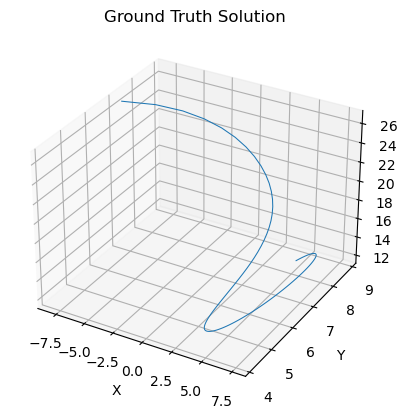

In [638]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs, lw=.75)
ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
ax.set_title("Ground Truth Solution")
plt.show()

In [639]:
# building the neural network

# they state they use a depth of 3
# with a width of 20
# then we add 3 dense layers so it can separately learn x, y, and z for the output function

class MLP_block(tf.keras.Model):
    def __init__(self, depth, width):
        super(MLP_block, self).__init__()

        # creating the sequence

        self.model_layers = self._make_layers(depth, width) # this returns a kera model to be used

        # learnable parameters
        # self.sigma = tf.Variable(1.0, trainable=True)
        # self.rho = tf.Variable(1.0, trainable=True)
        # self.beta = tf.Variable(1.0, trainable=True)
    
    @staticmethod
    def _make_layers(depth, width):

        # defines input shape without us knowing
        inputshape = tf.keras.layers.Input(shape=(1,))
        x = inputshape

        for _ in range(depth):
            layer = tf.keras.layers.Dense(width, activation='tanh',
                                          kernel_initializer="glorot_uniform")
            x = layer(x)
            x = tf.keras.layers.BatchNormalization()(x)
        
        # outputs
        # one for each predicted value
        x_out = tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", name='out1')(x)
        y_out = tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", name='out2')(x)
        z_out = tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", name='out3')(x)

        return tf.keras.Model(inputs=inputshape, outputs=[x_out, y_out, z_out])
    
    # def converter(self):
    #     # sigma = tf.convert_to_tensor(self.sigma, dtype=tf.float32)
    #     # rho = tf.convert_to_tensor(self.rho, dtype = tf.float32)
    #     # beta = tf.convert_to_tensor(self.beta, dtype = tf.float32)

    #     # exponentiate
    #     # rho = tf.exp(rho)
    #     # sigma = tf.exp(sigma)
    #     # beta = tf.exp(beta)

    #     return sigma, rho, beta


    def call(self, x):
        return self.model_layers(x)

In [640]:
def loss_function(u_true, y_pred):

    # loss for forward problem
    loss_x = tf.reduce_mean(tf.square(u_true[0] - y_pred[0]))
    loss_y = tf.reduce_mean(tf.square(u_true[1] - y_pred[1]))
    loss_z = tf.reduce_mean(tf.square(u_true[2] - y_pred[2]))

    # residual loss for inverse problem
    rx = tf.reduce_mean(tf.square(y_pred[3]))
    ry = tf.reduce_mean(tf.square(y_pred[4]))
    rz = tf.reduce_mean(tf.square(y_pred[5]))

    # loss for boundary conditions
    icx = (u_true[0][0] - y_pred[0][0])**2
    icy = (u_true[1][0] - y_pred[1][0])**2
    icz = (u_true[2][0] - y_pred[2][0])**2

    # print(loss_x+loss_y+loss_z, rx+ry+rz, icx+icy+icz)

    # larger weight given to incorrect x, y, and z terms
    # since this is an inverse problem, we add loss due to parameter terms

    forward_loss = loss_x + loss_y + loss_z
    r_loss = rx + ry + rz
    ic_loss = icx + icy + icz

    print(forward_loss.numpy().item(), r_loss.numpy().item(), ic_loss.numpy().item())
    
    return forward_loss + r_loss + 100 * ic_loss

In [641]:
pred_sigma = []
pred_rho = []
pred_beta = []
losses = []

In [642]:
# for loss
# they set weights wf, wb, and wi to 1

def train_lorenz(epochs=6000):
    sol = generate_lorenz_data(t=2)

    ts = sol.t
    xs = sol.y[0]
    ys = sol.y[1]
    zs = sol.y[2]


    sigma = 10.
    rho = 15.
    beta = 8/3

    # convert to tf tensors
    ts = tf.convert_to_tensor(ts, dtype=tf.float32)
    xs = tf.convert_to_tensor(xs, dtype=tf.float32)
    ys = tf.convert_to_tensor(ys, dtype=tf.float32)
    zs = tf.convert_to_tensor(zs, dtype=tf.float32)


    # define NN
    MLP = MLP_block(depth=7, width=40)

    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


        # training loop
    for epoch in range(epochs):

        with tf.GradientTape() as tape:

            # sigma2, rho2, beta2 = MLP.converter()

            with tf.GradientTape(persistent=True) as g:
                g.watch(ts)
                # forward pass
                [x, y, z] = MLP(ts)

            # finding the gradient with automatic differentiation
            dxdt = g.gradient(x, ts)
            dydt = g.gradient(y, ts)
            dzdt = g.gradient(z, ts)
            del g

            rx = dxdt - sigma * (y - x)
            ry = dydt - x * (rho - z) + y
            rz = dzdt - x * y + beta * z

            # pred_sigma.append(sigma2)
            # pred_rho.append(rho2)
            # pred_beta.append(beta2)

            y_pred = [x, y, z, rx, ry, rz]
        
            
            loss = loss_function(u_true=[xs, ys, zs], y_pred=y_pred)
            losses.append(loss)
        
        # grads = tape.gradient(loss, [MLP.rho, MLP.sigma, MLP.beta] + MLP.trainable_variables)        
        # optimizer.apply_gradients(zip(grads, [MLP.rho, MLP.sigma, MLP.beta] + MLP.trainable_variables))
        
        grads = tape.gradient(loss, MLP.trainable_variables)        
        optimizer.apply_gradients(zip(grads, MLP.trainable_variables))

        # plot the predicted figure every 100 epochs
        if epoch % 100 == 0:
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(x, y, z, lw=.75)
            ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
            ax.set_title(f"Epoch number: {epoch}")
            plt.show()

            print(sigma, rho, beta)

            # print(pred_sigma[-1].numpy().item(), pred_rho[-1].numpy().item(), pred_beta[-1].numpy().item())
            print(loss)
    tf.saved_model.save(MLP, "lorenz_inverse_0.1")

302.89959716796875 119.71284484863281 842.0


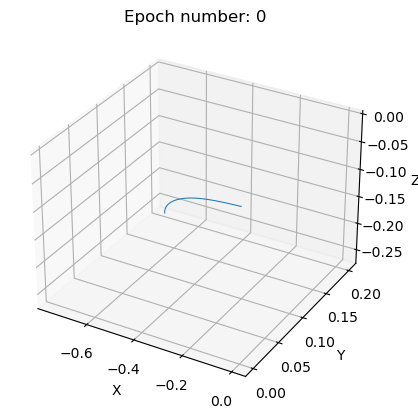

10.0 15.0 2.6666666666666665
tf.Tensor([84622.61], shape=(1,), dtype=float32)
266.9860534667969 498.83404541015625 808.4393310546875
241.9694366455078 70.98763275146484 740.5344848632812
209.8206024169922 578.7559204101562 635.5157470703125
180.57980346679688 1560.6710205078125 527.7010498046875
159.8508758544922 2335.943359375 450.1791076660156
144.8052978515625 2844.7998046875 401.057373046875
133.97537231445312 3156.8505859375 367.77801513671875
125.0355224609375 3141.42626953125 341.89959716796875
116.76258087158203 2812.393310546875 319.9416809082031
110.52145385742188 2297.5791015625 299.4604187011719
126.90286254882812 1947.57958984375 277.5120544433594
168.40896606445312 2552.453125 252.67770385742188
140.50735473632812 2523.671142578125 226.93063354492188
110.14625549316406 2904.8037109375 201.743408203125
102.81666564941406 3303.3994140625 178.3363037109375
103.88847351074219 3148.19189453125 157.3544921875
115.12881469726562 2567.356689453125 139.07528686523438
140.996826171

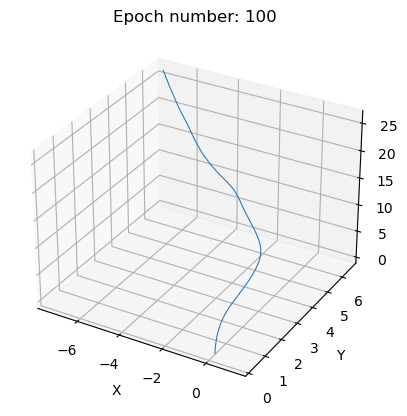

10.0 15.0 2.6666666666666665
tf.Tensor([1646.7185], shape=(1,), dtype=float32)
136.73097229003906 1471.9921875 0.5134894251823425
140.5604248046875 1462.0980224609375 0.5449560880661011
137.92831420898438 1419.577880859375 0.8974093198776245
133.95425415039062 1382.220458984375 1.3818477392196655
134.92904663085938 1373.442138671875 1.4622313976287842
138.62017822265625 1403.203125 1.0109977722167969
137.3216552734375 1442.1702880859375 0.6465685367584229
134.52093505859375 1448.937744140625 0.6185534000396729
135.55703735351562 1406.225830078125 0.910348117351532
138.25674438476562 1357.192138671875 1.440992832183838
136.90213012695312 1372.25244140625 1.2004622220993042
135.0875701904297 1415.2452392578125 0.8286540508270264
136.46893310546875 1401.944091796875 0.9096821546554565
138.15936279296875 1344.736328125 1.4849456548690796
136.48614501953125 1367.8502197265625 1.1861226558685303
135.15884399414062 1398.940673828125 0.9412988424301147
136.3684844970703 1360.899169921875 1.244

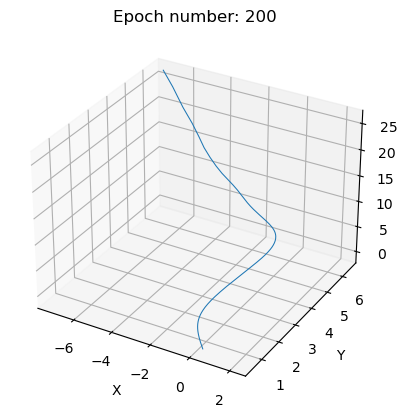

10.0 15.0 2.6666666666666665
tf.Tensor([1608.3011], shape=(1,), dtype=float32)
126.47412872314453 1322.5521240234375 1.4241340160369873
127.12117004394531 1344.916015625 1.112227439880371
126.13002014160156 1325.3585205078125 1.275702953338623
125.8796157836914 1346.951416015625 1.054060459136963
125.44139862060547 1311.27001953125 1.7363667488098145
126.75691223144531 1505.6328125 0.4026576280593872
127.51029968261719 1699.875244140625 0.32516786456108093
129.76470947265625 1870.120849609375 0.3629148304462433
129.6790771484375 2056.4443359375 0.5015782713890076
130.02139282226562 2112.67431640625 0.7617433667182922
130.51190185546875 1877.215087890625 1.1832494735717773
125.86058044433594 1659.882568359375 1.7477657794952393
126.41829681396484 1320.652587890625 2.703612804412842
121.52726745605469 1075.89404296875 8.898185729980469
123.63438415527344 1109.1082763671875 7.153998851776123
126.3708724975586 1432.6265869140625 2.041177749633789
125.18045043945312 1652.7291259765625 1.331

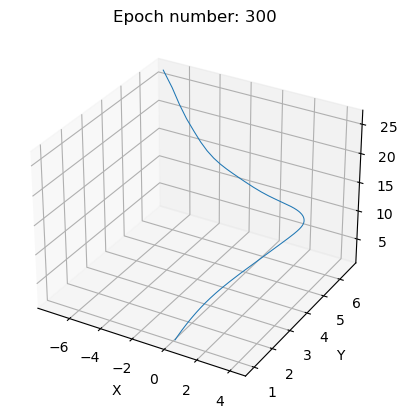

10.0 15.0 2.6666666666666665
tf.Tensor([1555.3926], shape=(1,), dtype=float32)
73.65840148925781 1359.3060302734375 1.1903215646743774
73.35136413574219 1401.99853515625 0.7135623097419739
72.64089965820312 1361.754150390625 1.0460811853408813
72.93209838867188 1405.039794921875 0.6515728235244751
72.5435562133789 1360.15673828125 1.4275603294372559
73.63090515136719 1560.1837158203125 0.42098039388656616
74.03988647460938 1601.7020263671875 0.421356737613678
73.6797866821289 1532.5208740234375 0.5473124980926514
73.67019653320312 1518.8924560546875 0.715867817401886
73.37675476074219 1494.0516357421875 0.90726238489151
73.09104919433594 1462.4908447265625 1.0972352027893066
73.472900390625 1465.54150390625 1.266094446182251
73.46298217773438 1422.6810302734375 1.486316442489624
73.10321044921875 1410.2899169921875 1.6542903184890747
71.93858337402344 1379.1275634765625 1.795908808708191
70.35189819335938 1236.112548828125 2.9674932956695557
71.29862976074219 1357.669189453125 1.694734

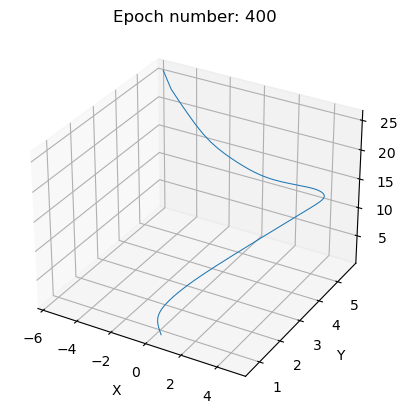

10.0 15.0 2.6666666666666665
tf.Tensor([2084.916], shape=(1,), dtype=float32)
76.07283020019531 1354.5252685546875 1.2922816276550293
82.11197662353516 1720.761962890625 0.4111766815185547
86.5210952758789 1914.4588623046875 0.3249291777610779
83.79443359375 1985.1441650390625 0.3801459074020386
85.211181640625 1927.6795654296875 0.5928006172180176
85.0488052368164 1768.546630859375 0.9898834228515625
80.04042053222656 1575.721923828125 1.5491193532943726
78.9783706665039 1368.29296875 2.4069066047668457
80.06005859375 1177.15380859375 5.009212493896484
77.50943756103516 1075.2445068359375 6.769104957580566
76.91162109375 1078.036376953125 6.836143493652344
81.91288757324219 1282.3421630859375 3.0604140758514404
84.4500732421875 1531.375732421875 0.710597038269043
82.3260726928711 1726.37451171875 0.20125284790992737
83.3299331665039 1772.36376953125 0.1039276048541069
79.1569595336914 1669.689697265625 0.12649425864219666
75.69165802001953 1526.275146484375 0.3962957262992859
75.11492

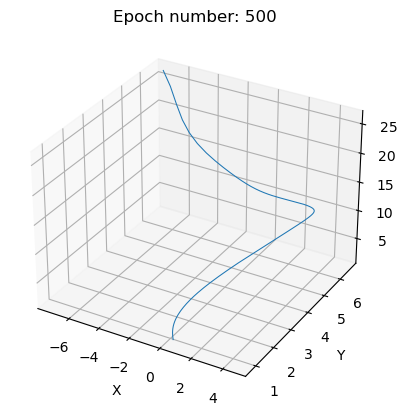

10.0 15.0 2.6666666666666665
tf.Tensor([1562.2157], shape=(1,), dtype=float32)
69.90373229980469 1443.1370849609375 0.5522303581237793
80.25496673583984 1417.24658203125 0.6396252512931824
75.24806213378906 1368.4903564453125 1.1317636966705322
71.94737243652344 1345.6424560546875 1.428374171257019
75.4455795288086 1376.30615234375 0.8931328058242798
71.14315795898438 1410.459716796875 0.7211490273475647
68.9517593383789 1392.7904052734375 0.8642843961715698
71.98673248291016 1342.04541015625 1.3187025785446167
73.3168716430664 1342.505615234375 1.2352490425109863
73.01676177978516 1386.2730712890625 0.8004324436187744
77.02064514160156 1394.2021484375 0.7246113419532776
76.9886474609375 1360.757080078125 0.9717864394187927
73.32333374023438 1345.109619140625 1.209431767463684
74.51313018798828 1369.5018310546875 0.8770616054534912
77.29286193847656 1382.298583984375 0.7678656578063965
75.37083435058594 1352.0267333984375 0.9954168200492859
75.41563415527344 1336.3421630859375 1.176310

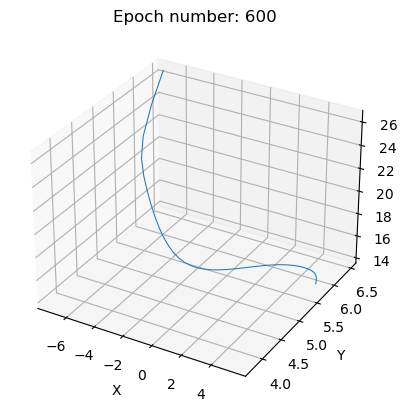

10.0 15.0 2.6666666666666665
tf.Tensor([1539.4102], shape=(1,), dtype=float32)
25.217041015625 1394.53662109375 1.1539312601089478
24.990102767944336 1413.9697265625 0.9434702396392822
24.883392333984375 1422.5755615234375 0.8616007566452026
24.838024139404297 1408.4697265625 0.964070200920105
24.971622467041016 1395.7755126953125 1.0764656066894531
25.364646911621094 1406.14599609375 0.9397963881492615
25.722633361816406 1417.81982421875 0.8183267116546631
25.775148391723633 1407.877197265625 0.8862354755401611
25.61046600341797 1389.953857421875 1.0434556007385254
25.50966453552246 1390.3033447265625 1.0180134773254395
25.480653762817383 1400.394775390625 0.9161615371704102
25.39657974243164 1395.7576904296875 0.9463707208633423
25.31466293334961 1382.370849609375 1.0556048154830933
25.409515380859375 1386.33740234375 0.9789831042289734
25.529661178588867 1395.9964599609375 0.8672254085540771
25.444257736206055 1386.5654296875 0.9372421503067017
25.321468353271484 1382.68408203125 0.

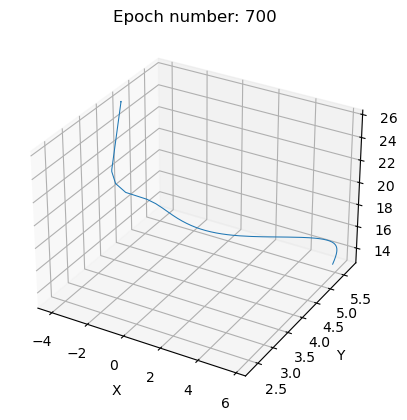

10.0 15.0 2.6666666666666665
tf.Tensor([6110.5747], shape=(1,), dtype=float32)
71.63339233398438 3487.147705078125 24.412689208984375
69.737548828125 3368.6796875 24.502954483032227
69.28599548339844 3377.103271484375 23.540822982788086
67.63264465332031 3429.1494140625 21.86821937561035
66.05868530273438 3511.85693359375 19.97737693786621
65.44651794433594 3586.882568359375 18.313030242919922
65.36119842529297 3573.242431640625 17.093542098999023
68.65545654296875 3560.630126953125 16.23019027709961
63.17920684814453 3519.180419921875 15.32436752319336
61.63873291015625 3481.834228515625 14.375871658325195
59.398895263671875 3471.4619140625 13.159282684326172
58.65370178222656 3504.96435546875 12.25139045715332
57.96083068847656 3478.955078125 11.72516918182373
57.656982421875 3313.2734375 11.365193367004395
58.34778594970703 3182.25634765625 11.203250885009766
57.787437438964844 3084.46044921875 11.223930358886719
55.7398681640625 3423.413330078125 10.766983032226562
51.9079933166503

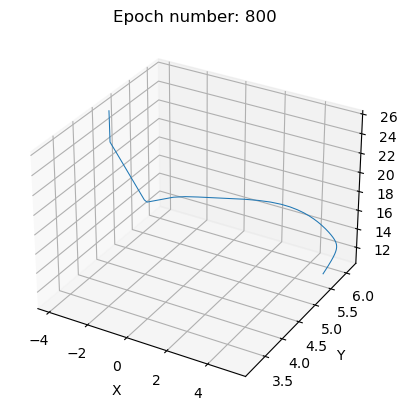

10.0 15.0 2.6666666666666665
tf.Tensor([5930.582], shape=(1,), dtype=float32)
72.03512573242188 3259.12744140625 25.096664428710938
75.99422454833984 3830.83251953125 19.73739242553711
75.62678527832031 3721.993896484375 18.805286407470703
73.90644073486328 3334.1767578125 18.725526809692383
71.55136108398438 2937.0390625 23.1542911529541
75.52751159667969 3569.854736328125 15.283905982971191
77.07910919189453 3900.31103515625 12.693410873413086
77.30430603027344 3984.76806640625 10.754308700561523
76.35482788085938 3766.507568359375 9.431943893432617
72.60370635986328 3079.14404296875 9.171518325805664
65.29473876953125 2010.18603515625 24.21761131286621
74.95317840576172 4364.171875 6.209659576416016
78.62149047851562 5647.41650390625 5.69959831237793
79.3482894897461 5725.53125 5.687069416046143
78.40082550048828 5078.65478515625 8.545226097106934
77.17570495605469 4502.1962890625 12.854656219482422
76.0771484375 4224.7900390625 16.532169342041016
75.20896911621094 3792.260986328125

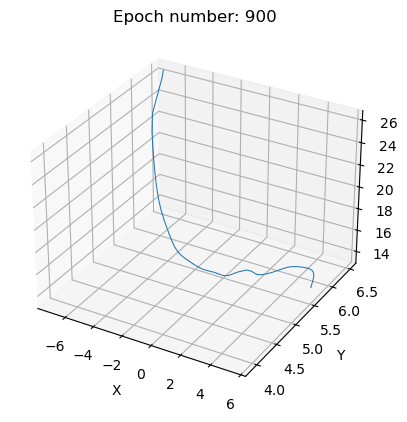

10.0 15.0 2.6666666666666665
tf.Tensor([1632.5431], shape=(1,), dtype=float32)
28.251590728759766 1442.233642578125 1.533240795135498
27.68121337890625 1418.7708740234375 1.6815314292907715
27.47409439086914 1421.7418212890625 1.6925958395004272
27.14263916015625 1440.849365234375 1.6892077922821045
27.73208236694336 1631.218994140625 1.521482229232788
27.648265838623047 1484.487060546875 1.5181410312652588
28.44942283630371 1497.887939453125 1.3720474243164062
28.393840789794922 1453.473876953125 1.4079786539077759
28.514400482177734 1434.1708984375 1.3775945901870728
28.153486251831055 1406.490478515625 1.426822543144226
27.750316619873047 1391.7255859375 1.434544324874878
27.42245864868164 1399.021240234375 1.3679687976837158
26.87454605102539 1480.350830078125 1.3552265167236328
27.82349395751953 1590.35498046875 1.044482946395874
29.249135971069336 1990.1209716796875 0.9153960943222046
29.769454956054688 2036.5546875 0.8890430331230164
30.48872947692871 1892.4539794921875 0.967382

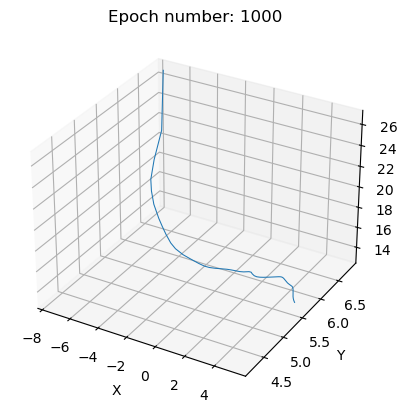

10.0 15.0 2.6666666666666665
tf.Tensor([1829.1366], shape=(1,), dtype=float32)
26.265361785888672 1600.51953125 0.329990953207016
23.791282653808594 888.582275390625 16.444194793701172
22.692092895507812 691.9635009765625 39.48893356323242
25.599720001220703 989.6080322265625 24.148155212402344
30.43967056274414 1603.1370849609375 11.323034286499023
35.636924743652344 2226.1708984375 2.676065444946289
41.77318572998047 2506.436279296875 0.07924764603376389
41.260223388671875 2406.259521484375 0.20908084511756897
33.20428466796875 2134.08447265625 0.6031267642974854
30.344541549682617 1853.7266845703125 0.8424996137619019
28.848827362060547 1698.08837890625 2.458111047744751
27.90553855895996 1530.323974609375 7.168170928955078
27.159202575683594 1578.62451171875 5.1209940910339355
27.202360153198242 1766.435791015625 0.7253082394599915
27.260114669799805 1889.5009765625 0.09471824765205383
26.253833770751953 1823.0587158203125 0.18705660104751587
24.337427139282227 1646.3524169921875 1

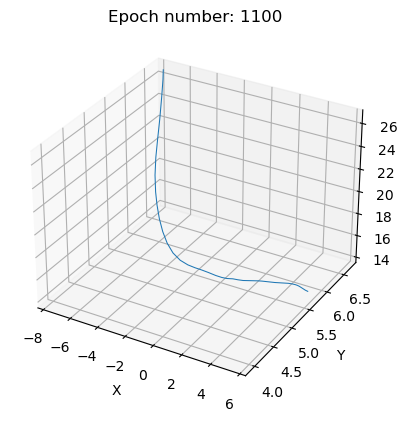

10.0 15.0 2.6666666666666665
tf.Tensor([1677.7651], shape=(1,), dtype=float32)
29.206661224365234 1888.2578125 0.29996564984321594
29.039752960205078 1898.6640625 0.3979418873786926
27.596485137939453 1766.335205078125 0.6972819566726685
25.900402069091797 1663.72412109375 1.2217315435409546
24.551660537719727 1589.204833984375 1.9061744213104248
23.82730484008789 1499.0721435546875 2.587944269180298
23.562042236328125 1457.28564453125 3.2163443565368652
24.973133087158203 1361.8572998046875 2.902777671813965
26.58163070678711 1479.8065185546875 2.4713759422302246
27.32847785949707 1554.4481201171875 2.220097541809082
26.88087272644043 1472.4552001953125 2.2743990421295166
25.668560028076172 1326.451171875 2.826448917388916
24.617382049560547 1256.973876953125 3.6581594944000244
24.530162811279297 1315.306396484375 2.759216070175171
25.051212310791016 1437.003173828125 1.3058326244354248
25.57680320739746 1527.03466796875 0.6289469599723816
25.932636260986328 1558.483154296875 0.382031

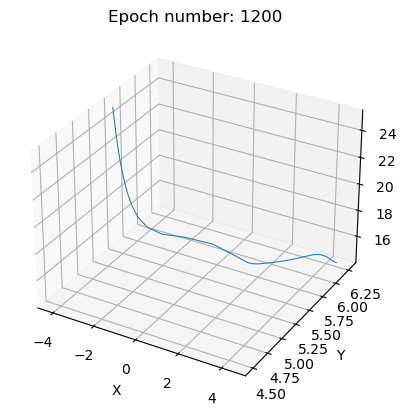

10.0 15.0 2.6666666666666665
tf.Tensor([3529.9126], shape=(1,), dtype=float32)
29.69915771484375 2044.2979736328125 11.29892349243164
31.660110473632812 2487.880859375 6.706235885620117
31.754026412963867 2511.234375 3.9507665634155273
29.06765365600586 1990.379638671875 2.919654369354248
26.43115997314453 1618.0615234375 1.2880390882492065
24.094820022583008 1436.340576171875 3.1211657524108887
27.97992706298828 2172.874267578125 1.0171045064926147
25.57076644897461 1352.0672607421875 10.332799911499023
27.623674392700195 1751.9990234375 2.8625664710998535
28.75642967224121 2056.100341796875 0.08177247643470764
25.49475860595703 1420.5009765625 3.5302252769470215
27.108951568603516 1734.7176513671875 0.07302853465080261
24.821086883544922 1252.13720703125 7.074210166931152
32.30463409423828 2809.2392578125 4.39538049697876
30.439613342285156 2427.364501953125 0.7714836597442627
25.920394897460938 1538.1885986328125 3.567624092102051
23.265865325927734 1096.1058349609375 16.19446563720

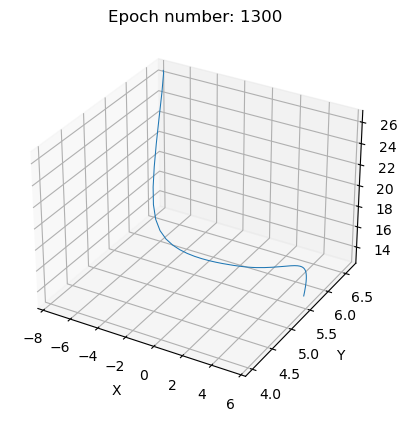

10.0 15.0 2.6666666666666665
tf.Tensor([1697.0743], shape=(1,), dtype=float32)
26.303842544555664 1504.79345703125 0.7773340344429016
25.101186752319336 1421.813720703125 1.2888274192810059
23.906139373779297 1272.7310791015625 4.33156681060791
26.055294036865234 1382.489501953125 1.3836537599563599
27.50345230102539 1526.5496826171875 0.9193137884140015
27.597736358642578 1545.2244873046875 0.818175196647644
26.66653060913086 1463.505126953125 0.9580744504928589
25.460304260253906 1348.9609375 1.5014642477035522
24.023815155029297 1320.136962890625 3.4625556468963623
25.682838439941406 1484.282470703125 0.7998114824295044
27.62531280517578 1615.43994140625 0.46696650981903076
28.43203353881836 1676.027099609375 0.45419642329216003
28.09283447265625 1612.411865234375 0.6242250800132751
27.100568771362305 1477.6192626953125 1.013195276260376
25.472015380859375 1375.6962890625 1.7490262985229492
23.83985137939453 1243.517333984375 4.280729293823242
25.024982452392578 1324.634033203125 1.

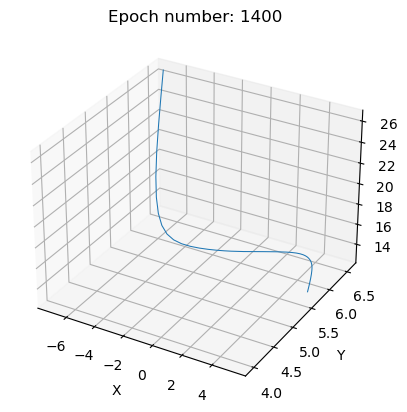

10.0 15.0 2.6666666666666665
tf.Tensor([1551.0391], shape=(1,), dtype=float32)
25.854415893554688 1376.35693359375 1.4619827270507812
27.2137393951416 1413.14990234375 1.0244957208633423
27.741466522216797 1429.670654296875 0.9253923296928406
27.01219940185547 1385.868896484375 1.272215485572815
26.340322494506836 1385.43994140625 1.2992186546325684
26.11475372314453 1431.4447021484375 0.7593082189559937
25.8303279876709 1451.6488037109375 0.5932777523994446
25.22049903869629 1411.33203125 0.9275450706481934
24.941370010375977 1370.916259765625 1.3884327411651611
25.41666030883789 1392.1788330078125 1.121517300605774
25.861196517944336 1419.0543212890625 0.8769572377204895
25.67917251586914 1397.905029296875 1.0325732231140137
25.416168212890625 1382.626953125 1.223309874534607
25.631229400634766 1403.923095703125 0.9735820293426514
25.984943389892578 1421.49853515625 0.8096791505813599
25.91692543029785 1397.662353515625 1.0110104084014893
25.611255645751953 1366.4580078125 1.34149193

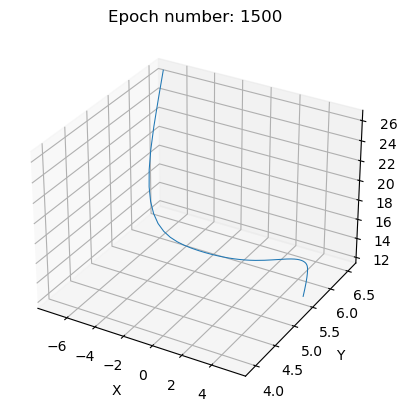

10.0 15.0 2.6666666666666665
tf.Tensor([1507.9874], shape=(1,), dtype=float32)
25.943546295166016 1385.8131103515625 0.9611098766326904
25.942668914794922 1385.49609375 0.9630778431892395
25.936004638671875 1385.3109130859375 0.9637830853462219
25.935924530029297 1385.384033203125 0.9618167877197266
25.93901824951172 1385.16259765625 0.9627499580383301
25.9361572265625 1385.02734375 0.9628595113754272
25.93761444091797 1385.1182861328125 0.9606510996818542
25.939376831054688 1385.033935546875 0.9601713418960571
25.932153701782227 1384.9227294921875 0.9600318670272827
25.92962646484375 1384.8922119140625 0.9590185284614563
25.930936813354492 1384.75732421875 0.9589949250221252
25.927032470703125 1384.587646484375 0.9593380689620972
25.928804397583008 1384.478515625 0.9589998722076416
25.933090209960938 1384.419921875 0.9580991268157959
25.93008041381836 1384.34619140625 0.9574043154716492
25.92938232421875 1384.25048828125 0.9568687677383423
25.929401397705078 1384.2115478515625 0.95573

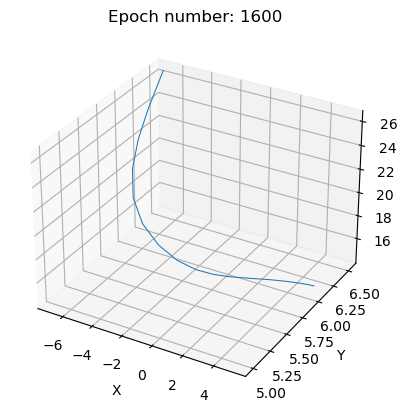

10.0 15.0 2.6666666666666665
tf.Tensor([1832.9939], shape=(1,), dtype=float32)
20.631210327148438 1736.488525390625 1.2920001745224
22.5294189453125 1543.6474609375 1.1728456020355225
28.501354217529297 1598.37939453125 1.5925251245498657
27.228649139404297 1455.7198486328125 2.7446699142456055
23.601226806640625 1420.823486328125 1.5928312540054321
22.312883377075195 1624.842529296875 0.8641331791877747
23.06175994873047 1611.06591796875 0.6299309730529785
25.54800033569336 1525.9625244140625 0.5605155825614929
28.656558990478516 1532.89111328125 0.7407454252243042
28.06766128540039 1461.517578125 1.525999903678894
25.386924743652344 1366.52392578125 2.021993398666382
24.481552124023438 1421.3585205078125 1.2218573093414307
24.441986083984375 1536.3304443359375 0.5810387134552002
24.442367553710938 1567.251220703125 0.3821122646331787
24.447751998901367 1494.4312744140625 0.5155647397041321
24.82144546508789 1415.58935546875 1.048757553100586
26.182716369628906 1417.40673828125 1.3406

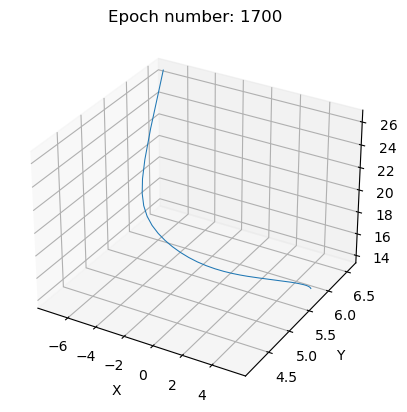

10.0 15.0 2.6666666666666665
tf.Tensor([1565.9956], shape=(1,), dtype=float32)
25.73593521118164 1490.509033203125 0.7016626596450806
26.155010223388672 1430.8778076171875 0.7557007074356079
25.231731414794922 1361.3458251953125 1.3685052394866943
24.317943572998047 1360.8306884765625 1.6790246963500977
24.743595123291016 1387.576904296875 0.8895402550697327
25.022464752197266 1441.4522705078125 0.710144579410553
24.894119262695312 1396.3675537109375 0.8041549921035767
24.517942428588867 1345.8935546875 1.4308594465255737
25.376136779785156 1338.678466796875 1.0468511581420898
25.62664031982422 1389.94677734375 0.7951205968856812
24.699302673339844 1321.074462890625 1.0450432300567627
24.44403076171875 1318.9150390625 1.2606593370437622
25.947053909301758 1560.7138671875 0.612739086151123
25.534948348999023 1306.762939453125 0.914837658405304
24.51891326904297 1422.391845703125 1.750614881515503
27.371170043945312 1527.353515625 0.4682237505912781
28.164960861206055 1709.9810791015625 

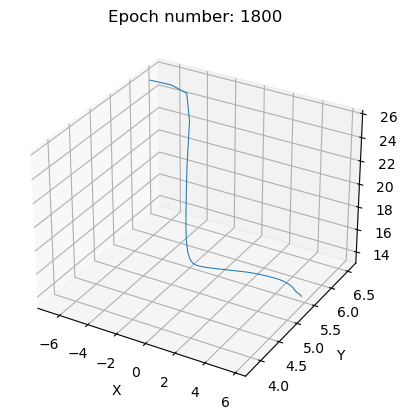

10.0 15.0 2.6666666666666665
tf.Tensor([1891.4835], shape=(1,), dtype=float32)
27.526607513427734 1687.400390625 1.6248136758804321
28.47779083251953 1759.549072265625 0.8375998139381409
29.45466423034668 1822.697509765625 0.4992167055606842
29.43680191040039 1849.0032958984375 0.4434678852558136
28.189199447631836 1760.94677734375 0.6576026678085327
26.63333511352539 1687.3292236328125 1.1956727504730225
25.250415802001953 1525.0643310546875 2.484748601913452
24.983171463012695 1499.0396728515625 2.2929580211639404
25.92530059814453 1581.152099609375 0.8363552689552307
26.823196411132812 1600.54296875 0.6411657333374023
27.326339721679688 1605.8216552734375 0.7534303665161133
26.991775512695312 1566.9114990234375 0.9788056015968323
26.37792205810547 1510.36767578125 1.3373514413833618
25.81827163696289 1447.368896484375 1.8570153713226318
25.320688247680664 1376.7607421875 2.5000905990600586
24.782136917114258 1312.3463134765625 3.2731680870056152
24.84845542907715 1381.1884765625 2.1

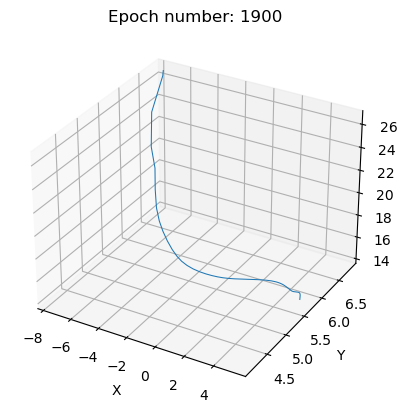

10.0 15.0 2.6666666666666665
tf.Tensor([1526.1072], shape=(1,), dtype=float32)
26.050355911254883 1434.6138916015625 0.31827008724212646
25.992223739624023 1444.207763671875 0.38048890233039856
26.47054100036621 1564.50927734375 0.37359195947647095
25.268264770507812 1775.91064453125 0.8471360802650452
22.029890060424805 782.017578125 26.578006744384766
21.555137634277344 693.4420166015625 34.401004791259766
26.657014846801758 1301.15185546875 13.409424781799316
31.211326599121094 2013.857666015625 6.879375457763672
32.482635498046875 2300.3447265625 3.623324394226074
31.420856475830078 2269.898193359375 2.071645975112915
29.982261657714844 2026.7801513671875 1.4720966815948486
27.8226318359375 1618.061279296875 2.6033620834350586
25.872568130493164 1314.92919921875 5.920668125152588
27.331300735473633 1420.1663818359375 3.2391040325164795
28.57794189453125 1607.019287109375 1.7088441848754883
27.994844436645508 1633.317626953125 1.28378427028656
25.971027374267578 1517.886474609375 1.

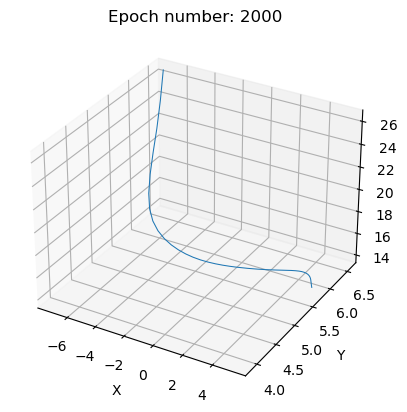

10.0 15.0 2.6666666666666665
tf.Tensor([1521.2947], shape=(1,), dtype=float32)
25.394859313964844 1385.547119140625 1.1102988719940186
25.477828979492188 1390.8555908203125 1.0432472229003906
25.61004066467285 1407.869384765625 0.8683687448501587
25.56966781616211 1408.0677490234375 0.8594461679458618
25.382522583007812 1392.191650390625 1.0079314708709717
25.29498863220215 1388.720947265625 1.0419468879699707
25.377296447753906 1403.807861328125 0.878505527973175
25.38805389404297 1406.6109619140625 0.8454196453094482
25.28699493408203 1391.75634765625 0.9807590842247009
25.293588638305664 1389.8062744140625 0.9901413917541504
25.404804229736328 1402.3804931640625 0.8523667454719543
25.36263084411621 1396.919921875 0.889808177947998
25.23916244506836 1383.936767578125 1.011868953704834
25.274417877197266 1393.85009765625 0.8881968259811401
25.222103118896484 1393.125244140625 0.8769329190254211
25.08241844177246 1379.5672607421875 0.9970841407775879
25.150409698486328 1392.13293457031

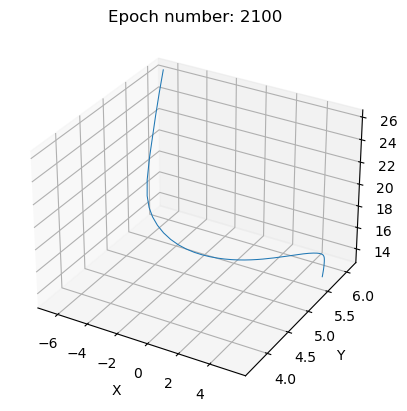

10.0 15.0 2.6666666666666665
tf.Tensor([2051.9338], shape=(1,), dtype=float32)
30.095996856689453 1624.59326171875 3.7271034717559814
30.042213439941406 1562.751708984375 3.6806540489196777
29.511659622192383 1520.24169921875 3.440716505050659
28.69739532470703 1483.868408203125 3.0273704528808594
27.73921012878418 1437.042236328125 2.628589153289795
27.05508041381836 1383.8359375 2.330728054046631
26.64188003540039 1343.925048828125 2.418006181716919
26.150726318359375 1301.395751953125 2.678370237350464
25.796947479248047 1319.091796875 2.542696475982666
26.663986206054688 1384.496337890625 0.8144975304603577
27.832597732543945 1532.5679931640625 0.21571789681911469
26.672042846679688 1407.307861328125 0.47538483142852783
26.223695755004883 1387.58447265625 0.15225611627101898
25.390438079833984 1353.2294921875 0.2865409255027771
25.56829833984375 1673.107421875 0.11626093089580536
22.31446075439453 1050.55517578125 18.445215225219727
24.083404541015625 1085.9296875 9.768619537353516

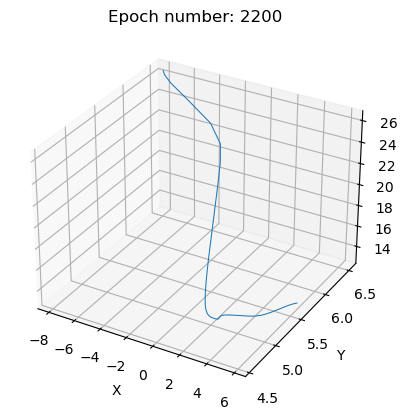

10.0 15.0 2.6666666666666665
tf.Tensor([3528.293], shape=(1,), dtype=float32)
36.02594757080078 3053.53759765625 0.9052475690841675
33.72802734375 2652.500244140625 1.925605058670044
30.90526008605957 2320.535400390625 3.4317314624786377
28.10797882080078 2010.0107421875 5.232156753540039
25.926042556762695 1751.17919921875 7.093857288360596
23.674938201904297 1451.92529296875 9.541428565979004
22.454072952270508 1259.69384765625 12.310328483581543
22.70476531982422 1253.178955078125 11.034917831420898
24.416614532470703 1394.6390380859375 7.038877010345459
26.49022674560547 1568.7354736328125 4.99945068359375
27.945035934448242 1707.2490234375 3.8058245182037354
28.142704010009766 1746.8006591796875 2.9524245262145996
26.968097686767578 1668.619384765625 2.3604633808135986
24.9316463470459 1524.259765625 2.176314115524292
22.87576675415039 1380.1973876953125 3.3507323265075684
22.24544906616211 1387.528076171875 2.9850258827209473
22.914451599121094 1557.109619140625 1.194017767906189

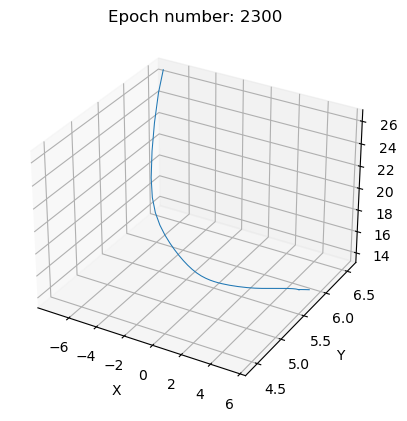

10.0 15.0 2.6666666666666665
tf.Tensor([1575.1448], shape=(1,), dtype=float32)
25.031686782836914 1365.76953125 1.2568713426589966
24.912181854248047 1348.3388671875 2.098719596862793
25.389482498168945 1388.7578125 1.10173499584198
25.43172836303711 1458.14453125 0.6403622627258301
24.78106689453125 1452.9437255859375 0.6400489807128906
23.84735870361328 1371.563720703125 1.1533863544464111
23.545921325683594 1358.609375 1.626238465309143
24.564067840576172 1456.435302734375 0.6106351017951965
25.111276626586914 1445.300537109375 0.6037624478340149
24.92566680908203 1361.0205078125 1.4688884019851685
25.376506805419922 1371.2757568359375 0.9320330619812012
25.3785400390625 1421.622802734375 0.6793862581253052
24.537492752075195 1332.7374267578125 1.175899624824524
24.180925369262695 1330.6820068359375 1.0648490190505981
24.030162811279297 1353.10009765625 0.90328049659729
23.55086898803711 1403.68115234375 2.211965799331665
26.564468383789062 1721.40283203125 0.3813541531562805
28.514

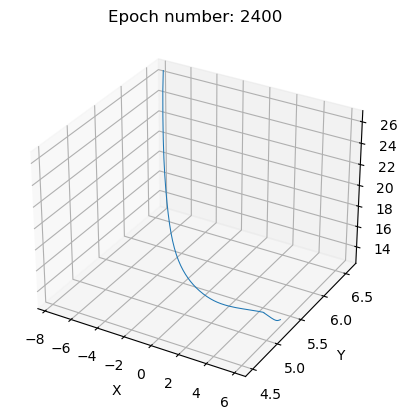

10.0 15.0 2.6666666666666665
tf.Tensor([1665.6257], shape=(1,), dtype=float32)
25.793113708496094 1529.8197021484375 1.2003847360610962
25.643688201904297 1545.1201171875 0.9817909598350525
26.16217041015625 1610.2291259765625 0.2367568016052246
24.400123596191406 1547.9267578125 0.48717930912971497
23.003498077392578 1448.1822509765625 1.5055856704711914
25.250633239746094 1554.819580078125 0.3956006169319153
23.91748046875 1468.470703125 0.9806796312332153
22.145187377929688 1368.9893798828125 2.4077184200286865
25.110132217407227 1570.7421875 0.38441887497901917
23.949234008789062 1485.0693359375 0.7618882060050964
22.079233169555664 1337.62109375 2.780426502227783
25.828964233398438 1518.259033203125 0.5697500705718994
25.79581069946289 1488.0185546875 0.7035505771636963
23.119976043701172 1328.233642578125 2.508875608444214
24.438358306884766 1402.30810546875 1.31501042842865
26.150348663330078 1490.8726806640625 0.6841938495635986
25.174942016601562 1414.5908203125 1.169240951538

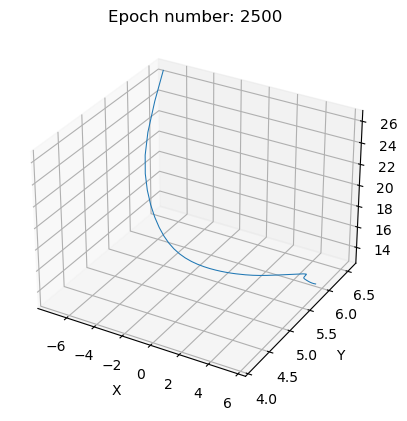

10.0 15.0 2.6666666666666665
tf.Tensor([1513.2296], shape=(1,), dtype=float32)
25.279125213623047 1390.6416015625 0.9711698293685913
25.302345275878906 1391.763671875 0.9577107429504395
25.304813385009766 1391.78076171875 0.9555139541625977
25.286380767822266 1390.49951171875 0.9664600491523743
25.291419982910156 1390.3280029296875 0.9660652875900269
25.312469482421875 1391.1435546875 0.9556169509887695
25.307706832885742 1390.838134765625 0.9565843343734741
25.289926528930664 1389.8162841796875 0.9648388624191284
25.297876358032227 1389.8629150390625 0.9620885252952576
25.31568145751953 1390.321044921875 0.9551035165786743
25.30955696105957 1389.723876953125 0.9588493704795837
25.29730224609375 1388.92724609375 0.9646326303482056
25.307193756103516 1389.124755859375 0.9601755142211914
25.320281982421875 1389.313232421875 0.9557571411132812
25.314815521240234 1388.59423828125 0.9605188369750977
25.30972671508789 1388.053466796875 0.9634631276130676
25.319808959960938 1388.3394775390625

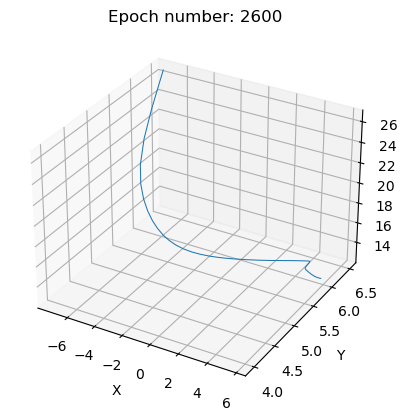

10.0 15.0 2.6666666666666665
tf.Tensor([1576.8549], shape=(1,), dtype=float32)
26.58318519592285 1383.6884765625 1.2046067714691162
25.528640747070312 1321.436767578125 2.43300724029541
25.558626174926758 1339.951416015625 1.4264551401138306
26.038188934326172 1432.9658203125 0.7444889545440674
26.51428985595703 1466.5836181640625 0.6301371455192566
26.796878814697266 1445.972412109375 0.6904504895210266
26.310630798339844 1341.094482421875 1.1603814363479614
25.400772094726562 1353.7459716796875 2.3010833263397217
27.106990814208984 1500.786376953125 0.5430295467376709
28.17435073852539 1641.373291015625 0.28224658966064453
28.24713897705078 1715.8172607421875 0.23179872334003448
27.992919921875 1712.9814453125 0.314852237701416
27.859172821044922 1638.8984375 0.5221031308174133
27.537452697753906 1541.5301513671875 0.8676937222480774
26.795024871826172 1419.874267578125 1.4088513851165771
25.978527069091797 1413.0126953125 1.8956069946289062
25.61328125 1218.776611328125 2.6240971088

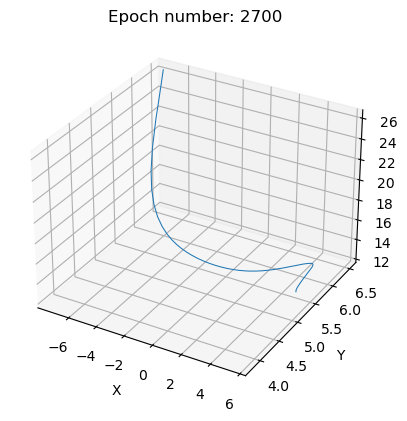

10.0 15.0 2.6666666666666665
tf.Tensor([1589.9219], shape=(1,), dtype=float32)
26.929574966430664 1439.036865234375 1.0648562908172607
26.29959487915039 1400.752685546875 1.3061593770980835
24.803754806518555 1325.7388916015625 2.0114827156066895
24.13996124267578 1313.7276611328125 2.324464797973633
25.503700256347656 1390.5364990234375 1.1778368949890137
26.653915405273438 1452.1290283203125 0.7628939151763916
26.409156799316406 1449.9765625 0.7364795804023743
25.60595703125 1406.66796875 0.9959819316864014
25.400976181030273 1349.910888671875 1.6117138862609863
26.43107032775879 1359.0045166015625 1.4985058307647705
27.419281005859375 1409.638671875 0.9544135928153992
26.736177444458008 1419.4241943359375 0.7900505661964417
25.309345245361328 1409.8212890625 0.8740183711051941
24.81800079345703 1385.904052734375 1.1192911863327026
25.687042236328125 1378.2352294921875 1.0881303548812866
26.722457885742188 1412.685302734375 0.794073760509491
26.326692581176758 1415.951904296875 0.720

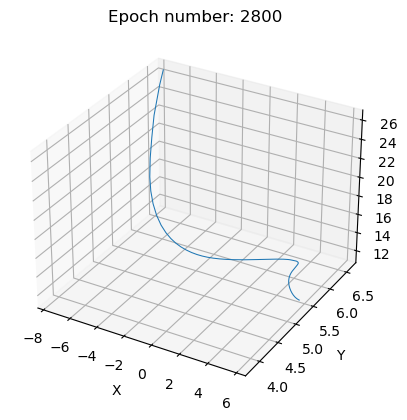

10.0 15.0 2.6666666666666665
tf.Tensor([1583.5068], shape=(1,), dtype=float32)
25.731958389282227 1473.85986328125 0.5830707550048828
25.20209503173828 1428.011962890625 0.7738571763038635
26.144119262695312 1433.470703125 1.0637521743774414
27.329383850097656 1451.4012451171875 1.0221105813980103
27.27910041809082 1433.09033203125 0.7445374131202698
26.05986785888672 1431.22998046875 0.5618019700050354
25.10635757446289 1458.669677734375 0.5516703128814697
25.166709899902344 1387.9658203125 0.6328523755073547
25.804615020751953 1361.952392578125 0.8851126432418823
26.73089599609375 1332.032470703125 0.7820690274238586
26.450790405273438 1322.131591796875 0.7871130108833313
25.03862190246582 1230.4193115234375 1.0815688371658325
24.227020263671875 1207.3284912109375 1.0162601470947266
23.610675811767578 1185.340576171875 1.3119686841964722
25.365619659423828 1986.1318359375 0.8812949657440186
35.89469909667969 2545.48583984375 0.8267565369606018
41.63362121582031 2993.8310546875 0.9838

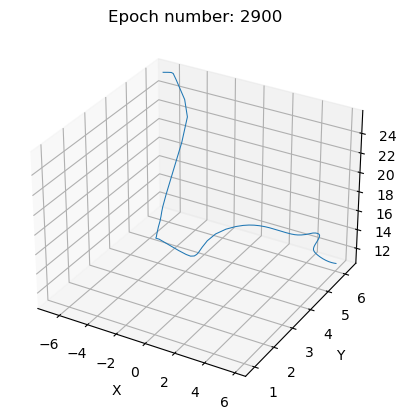

10.0 15.0 2.6666666666666665
tf.Tensor([2828.2595], shape=(1,), dtype=float32)
44.406978607177734 2153.81201171875 3.105250597000122
42.07255935668945 1728.04248046875 10.393754959106445
50.98733901977539 3271.556396484375 1.1973655223846436
58.59916687011719 4292.69677734375 0.7031826972961426
65.00678253173828 4871.7607421875 0.6361848711967468
65.9156494140625 4835.88330078125 1.1953470706939697
62.47783660888672 4404.05859375 2.8510661125183105
58.86850357055664 3919.169189453125 5.7096686363220215
56.679847717285156 3412.04736328125 9.327791213989258
55.7276611328125 3066.9150390625 12.999099731445312
54.42329025268555 2845.95751953125 16.05879783630371
51.671974182128906 2637.523193359375 17.87095832824707
49.113426208496094 2731.881591796875 18.06147575378418
49.685672760009766 2748.04736328125 16.841209411621094
50.631141662597656 2864.7548828125 14.892644882202148
51.454681396484375 3010.57470703125 12.781129837036133
52.777870178222656 3118.212646484375 10.793341636657715
53.

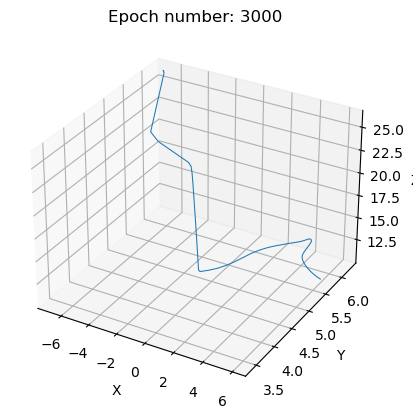

10.0 15.0 2.6666666666666665
tf.Tensor([3037.6206], shape=(1,), dtype=float32)
43.457359313964844 4356.90185546875 2.3069088459014893
37.86424255371094 3249.4541015625 2.662126064300537
32.43887710571289 2668.7509765625 3.2529802322387695
25.73029136657715 3464.713134765625 3.8630361557006836
21.055150985717773 527.1724243164062 123.60275268554688
36.155853271484375 1943.27734375 63.83842468261719
52.08299255371094 3766.889892578125 39.72663116455078
64.15802764892578 4344.64404296875 22.239887237548828
72.26673126220703 4720.6435546875 11.722113609313965
70.05398559570312 4452.27001953125 10.072528839111328
61.60704040527344 4316.81494140625 9.874492645263672
51.16107177734375 3241.021484375 9.500371932983398
42.24778747558594 2720.36767578125 9.305985450744629
35.99893569946289 2193.939208984375 10.076517105102539
33.34598922729492 1898.778076171875 13.513038635253906
32.59134292602539 1774.802001953125 13.805595397949219
31.61378288269043 1780.673583984375 9.441434860229492
29.84959

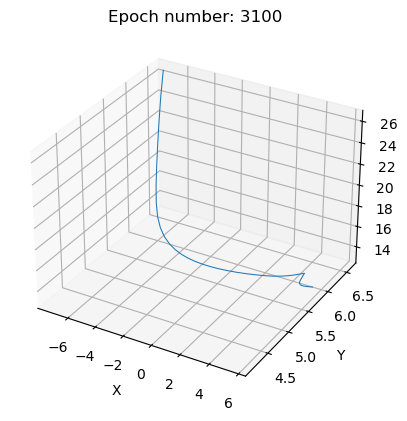

10.0 15.0 2.6666666666666665
tf.Tensor([1519.3823], shape=(1,), dtype=float32)
25.171464920043945 1414.926513671875 0.7858737111091614
24.97415542602539 1385.241943359375 1.0600448846817017
24.92801284790039 1370.367919921875 1.2221086025238037
25.161727905273438 1392.088134765625 0.9716042280197144
25.339908599853516 1411.73388671875 0.7846981287002563
25.240074157714844 1400.7322998046875 0.8737652897834778
25.01699447631836 1377.6510009765625 1.1062531471252441
24.992216110229492 1381.546142578125 1.0551493167877197
25.139328002929688 1403.736083984375 0.824202299118042
25.199275970458984 1405.5189208984375 0.7997370958328247
25.130603790283203 1385.7811279296875 0.9834259152412415
25.12832260131836 1380.11181640625 1.037333607673645
25.242877960205078 1397.0167236328125 0.8521884679794312
25.26962661743164 1401.749755859375 0.8019965887069702
25.178112030029297 1385.2197265625 0.953106164932251
25.157470703125 1379.16845703125 1.0101568698883057
25.263927459716797 1394.242553710937

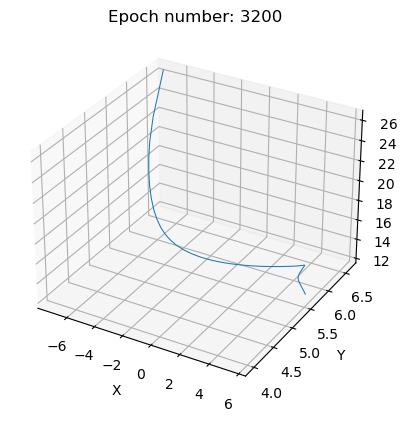

10.0 15.0 2.6666666666666665
tf.Tensor([1421.2998], shape=(1,), dtype=float32)
24.219318389892578 1279.699951171875 1.1214661598205566
24.404178619384766 1784.91162109375 0.3654228746891022
24.949222564697266 1436.0537109375 8.168539047241211
28.259639739990234 1237.6337890625 8.345853805541992
28.715242385864258 1483.5208740234375 2.6041409969329834
23.524883270263672 1506.51953125 1.574976921081543
24.476951599121094 1556.494384765625 0.657178521156311
27.31943702697754 1583.658447265625 0.522411048412323
24.707509994506836 1140.53759765625 9.759966850280762
44.79832458496094 3629.04541015625 0.6533403396606445
40.84013366699219 3484.21923828125 0.4912777245044708
32.026100158691406 3126.396484375 0.243954598903656
34.60431671142578 2411.7373046875 0.6309877634048462
37.54041290283203 2128.0498046875 1.6968458890914917
32.77140426635742 1710.292236328125 3.2916595935821533
26.206268310546875 1380.7579345703125 11.344019889831543
28.674617767333984 1562.4566650390625 3.616636753082275

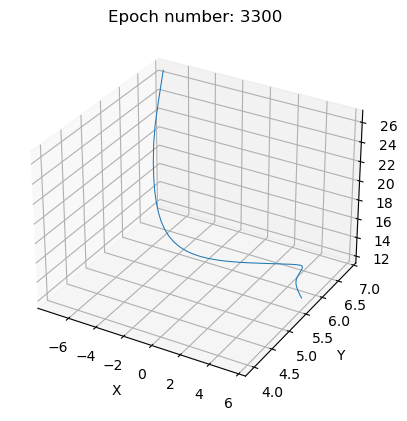

10.0 15.0 2.6666666666666665
tf.Tensor([1502.3494], shape=(1,), dtype=float32)
26.033679962158203 1462.94580078125 0.29592278599739075
24.998245239257812 1429.859375 0.40560513734817505
24.924785614013672 1375.4254150390625 0.9467079043388367
26.373790740966797 1355.0023193359375 0.7514711618423462
27.092254638671875 1383.3853759765625 0.6691193580627441
26.02178192138672 1300.415771484375 1.1287990808486938
25.02486228942871 1280.020751953125 1.135511875152588
24.64453125 1306.3046875 0.9002772569656372
24.16205596923828 1337.23095703125 1.8249552249908447
27.09893035888672 1425.0439453125 0.4404362142086029
28.47185707092285 1603.4268798828125 0.3953647315502167
28.81237030029297 1767.7080078125 0.45646318793296814
29.566478729248047 1980.920166015625 0.6107860803604126
28.977375030517578 2304.46826171875 0.9106593728065491
24.443164825439453 1551.7314453125 1.4283677339553833
22.902278900146484 2024.3095703125 2.1434783935546875
17.86872100830078 417.1910400390625 80.50761413574219


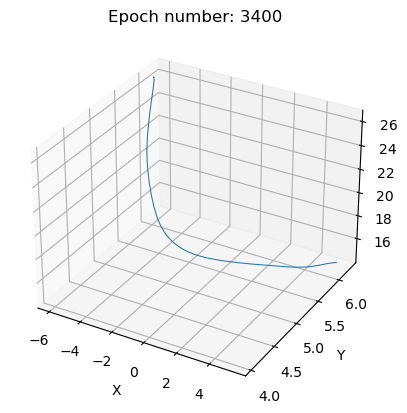

10.0 15.0 2.6666666666666665
tf.Tensor([3353.1519], shape=(1,), dtype=float32)
43.11328125 2778.00634765625 5.282619476318359
40.096656799316406 2693.77294921875 5.380938529968262
37.09415054321289 2716.7275390625 5.581040382385254
35.96281433105469 2697.267578125 5.802463531494141
36.71648406982422 2559.0068359375 5.970695495605469
38.26976776123047 2460.54052734375 6.001750469207764
39.63982391357422 2428.5322265625 5.764124870300293
40.540897369384766 2456.303955078125 5.178409576416016
40.646453857421875 2465.423828125 4.443882942199707
39.725975036621094 2412.9365234375 3.892411708831787
37.80677032470703 2287.53662109375 3.599382162094116
35.58386993408203 2160.03662109375 3.4380929470062256
33.513511657714844 1981.5423583984375 3.3021438121795654
31.72056007385254 1762.6153564453125 3.1809301376342773
30.233415603637695 1533.16943359375 3.2962613105773926
29.15241241455078 1363.762939453125 5.084325313568115
29.325199127197266 1406.583251953125 4.165632247924805
30.2526683807373

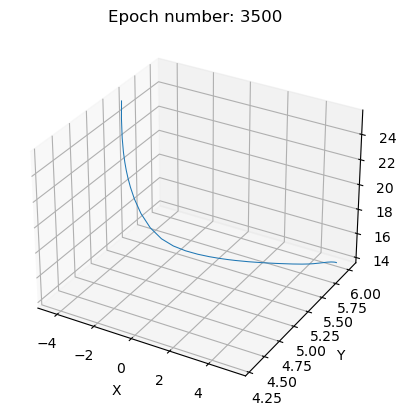

10.0 15.0 2.6666666666666665
tf.Tensor([2772.2095], shape=(1,), dtype=float32)
29.365137100219727 1906.6259765625 8.884354591369629
32.113277435302734 2286.28076171875 5.631182670593262
34.19001007080078 2373.34130859375 3.8830745220184326
33.66508483886719 2258.597900390625 2.967341661453247
28.150306701660156 1766.427978515625 2.8345787525177
23.963581085205078 1230.38916015625 11.942325592041016
27.580018997192383 1531.6885986328125 2.7969536781311035
30.203426361083984 1815.4453125 1.2978399991989136
21.881481170654297 1712.7783203125 1.9897000789642334
23.868309020996094 1448.476318359375 1.7961300611495972
32.63702392578125 1906.72119140625 0.8282730579376221
19.793495178222656 1381.038818359375 14.283116340637207
78.14476013183594 7369.39501953125 0.294694721698761
37.888877868652344 3325.83740234375 0.17392952740192413
36.410316467285156 5337.6669921875 0.2701817750930786
37.132328033447266 3303.25634765625 0.514535129070282
90.16763305664062 6189.0947265625 1.0876299142837524


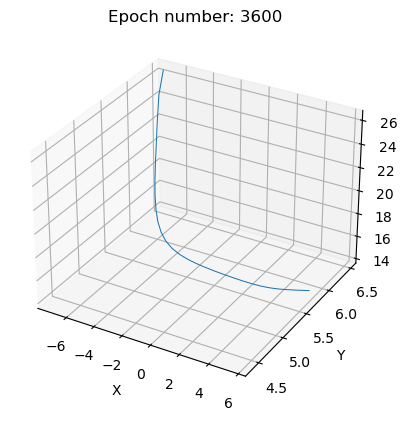

10.0 15.0 2.6666666666666665
tf.Tensor([1540.4288], shape=(1,), dtype=float32)
25.489990234375 1397.5 1.2309919595718384
25.18536376953125 1389.479248046875 1.214806079864502
24.64626693725586 1382.886962890625 1.1265641450881958
24.21145248413086 1388.8692626953125 0.9459397792816162
24.13260269165039 1403.719482421875 0.6966620087623596
24.347148895263672 1415.619140625 0.502932608127594
24.582563400268555 1411.564453125 0.44409990310668945
24.788063049316406 1399.0986328125 0.4656173288822174
25.00218963623047 1383.7183837890625 0.4687768518924713
24.910282135009766 1361.74462890625 0.5076768398284912
24.430538177490234 1328.55322265625 0.6193200945854187
23.935327529907227 1300.9010009765625 0.7003969550132751
23.632076263427734 1281.614501953125 0.7268257141113281
23.50058364868164 1257.8870849609375 0.7692370414733887
23.660192489624023 1235.14990234375 0.7718937397003174
24.08401870727539 1219.349853515625 0.7088572978973389
24.467079162597656 1207.4434814453125 0.65615439414978

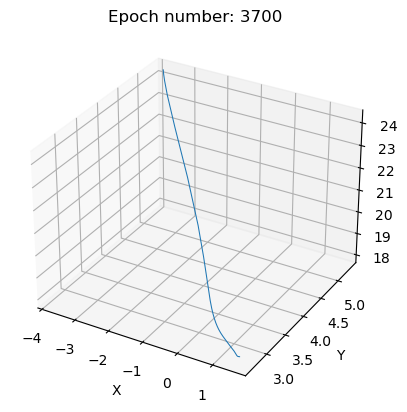

10.0 15.0 2.6666666666666665
tf.Tensor([5621.331], shape=(1,), dtype=float32)
53.9981689453125 2996.94873046875 20.72856903076172
51.17454528808594 3159.625732421875 18.390239715576172
53.90399932861328 3829.3759765625 8.654828071594238
49.84449005126953 3661.398681640625 7.535159587860107
42.28727722167969 2047.3824462890625 119.43257141113281
48.15078353881836 2348.59228515625 67.60462951660156
59.35821533203125 3078.660888671875 25.87946128845215
74.97593688964844 5348.10107421875 15.341471672058105
76.30028533935547 6523.0380859375 16.63273048400879
66.97261047363281 6304.56640625 13.175469398498535
54.50934600830078 5451.1376953125 7.3499956130981445
46.3253173828125 4698.99365234375 2.486164093017578
41.05107116699219 4018.6474609375 0.6767016053199768
36.34638595581055 3398.01904296875 2.0578231811523438
32.544498443603516 2774.513671875 5.670218467712402
29.70914077758789 2134.5498046875 11.237957000732422
26.791662216186523 1453.647705078125 33.70512771606445
28.73076248168945

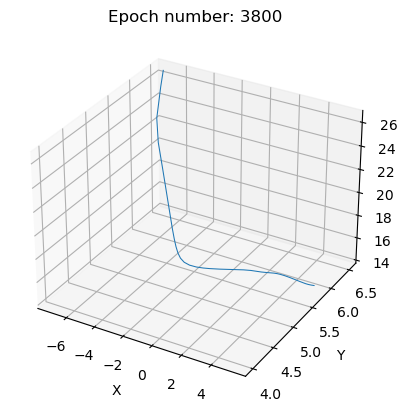

10.0 15.0 2.6666666666666665
tf.Tensor([1603.7784], shape=(1,), dtype=float32)
23.981138229370117 1425.7412109375 1.6037507057189941
24.064105987548828 1347.3157958984375 2.292220115661621
24.858497619628906 1332.361083984375 2.251732110977173
25.903915405273438 1403.1875 1.4970295429229736
26.41192626953125 1467.2060546875 1.0175269842147827
26.109569549560547 1478.9716796875 0.8363617062568665
25.226051330566406 1463.1146240234375 0.81760573387146
24.237525939941406 1445.3951416015625 0.9420312643051147
23.43699073791504 1391.423583984375 1.4216443300247192
23.080970764160156 1344.767822265625 2.179276943206787
23.833677291870117 1401.246826171875 1.1813441514968872
24.61829948425293 1449.37744140625 0.8130393028259277
25.065814971923828 1464.5196533203125 0.7572383880615234
24.969066619873047 1432.93408203125 0.9483372569084167
24.393428802490234 1368.5950927734375 1.5761144161224365
24.09722137451172 1372.018798828125 1.3731589317321777
24.119304656982422 1438.60595703125 0.7705488

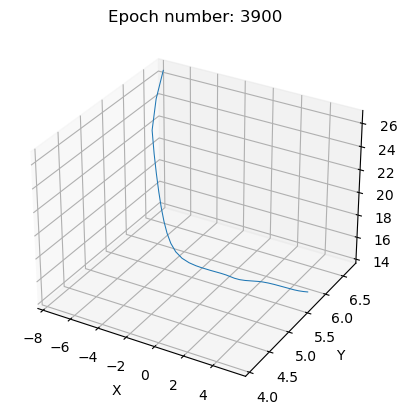

10.0 15.0 2.6666666666666665
tf.Tensor([1599.3278], shape=(1,), dtype=float32)
25.004112243652344 1417.47021484375 0.7716166377067566
24.421947479248047 1337.843017578125 2.665067672729492
25.291553497314453 1367.071533203125 1.3383830785751343
26.13791275024414 1466.562255859375 0.6306606531143188
26.431644439697266 1500.3291015625 0.47403421998023987
26.187969207763672 1498.18505859375 0.4827110171318054
25.602218627929688 1473.047119140625 0.6242311596870422
25.05091094970703 1436.9638671875 0.9296355247497559
24.786563873291016 1387.3162841796875 1.413420557975769
24.87884521484375 1346.39990234375 1.8708746433258057
25.292776107788086 1347.552001953125 1.8318361043930054
25.771331787109375 1383.939208984375 1.386131763458252
25.98361587524414 1420.43212890625 1.0074450969696045
25.806503295898438 1436.4169921875 0.8362711668014526
25.331073760986328 1427.29833984375 0.8593903183937073
24.711994171142578 1379.99072265625 1.1825610399246216
24.283172607421875 1351.750732421875 1.636

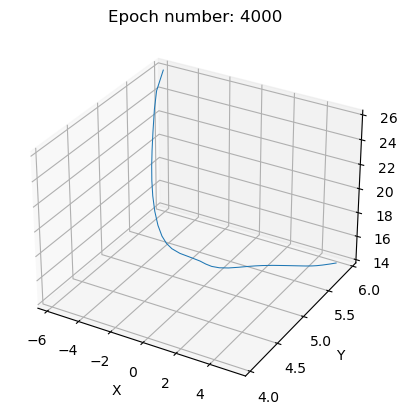

10.0 15.0 2.6666666666666665
tf.Tensor([1908.1753], shape=(1,), dtype=float32)
26.3314208984375 1398.998779296875 3.2522454261779785
27.685821533203125 1556.01171875 0.7562459707260132
28.31307601928711 1668.311767578125 0.22334468364715576
27.71552276611328 1701.10009765625 0.16898173093795776
26.481769561767578 1708.041748046875 0.15341618657112122
25.391918182373047 1656.171142578125 0.19645395874977112
24.272380828857422 1597.9947509765625 0.6067665815353394
24.3330078125 1455.312255859375 1.3690518140792847
24.54545783996582 1319.655029296875 3.0866098403930664
25.697452545166016 1342.752197265625 2.675790309906006
26.890478134155273 1435.369140625 1.7842049598693848
27.66783905029297 1488.821044921875 1.2611063718795776
27.849411010742188 1507.193603515625 0.9701529741287231
27.27704620361328 1481.86865234375 0.8636967539787292
26.161163330078125 1454.99462890625 0.8888099193572998
25.063026428222656 1464.492431640625 0.984764039516449
24.245059967041016 1436.33203125 1.244603991

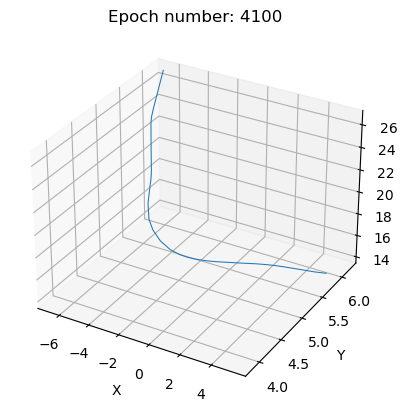

10.0 15.0 2.6666666666666665
tf.Tensor([2152.776], shape=(1,), dtype=float32)
31.889972686767578 1753.412109375 2.2990622520446777
30.201026916503906 1593.1763916015625 2.293891668319702
28.487218856811523 1408.9091796875 3.403489112854004
27.261005401611328 1316.306396484375 6.374849796295166
26.912303924560547 1520.5584716796875 4.602044105529785
28.265501022338867 1809.482421875 0.42474910616874695
29.326946258544922 1757.220947265625 0.17546965181827545
30.615758895874023 2229.0849609375 0.09586098045110703
28.633424758911133 3236.24169921875 0.07977835834026337
34.334205627441406 6145.67626953125 0.1135648638010025
26.581207275390625 2720.046142578125 0.30416634678840637
26.470367431640625 2127.08251953125 0.6056157350540161
25.210254669189453 2027.05078125 0.9963210821151733
24.86349105834961 1737.3284912109375 1.4218450784683228
24.09120750427246 1553.947021484375 1.8163814544677734
23.705978393554688 2478.958740234375 2.1286489963531494
26.324565887451172 2739.45849609375 2.322

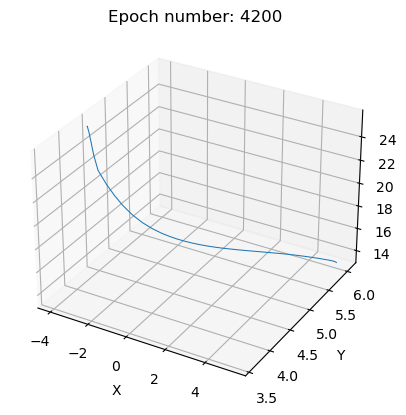

10.0 15.0 2.6666666666666665
tf.Tensor([6494.221], shape=(1,), dtype=float32)
73.11958312988281 4005.19970703125 24.1167049407959
73.03514099121094 3959.159912109375 24.09593391418457
72.06137084960938 3887.17919921875 24.12188720703125
71.00856018066406 3907.2587890625 24.15409278869629
70.24090576171875 3818.956787109375 24.146587371826172
69.97216033935547 3820.614501953125 24.069246292114258
69.75605773925781 3807.814697265625 23.90853500366211
70.27128601074219 3750.4765625 23.657817840576172
70.1899185180664 3775.68505859375 23.348058700561523
70.19535827636719 3825.810546875 22.988935470581055
69.55895233154297 3767.2216796875 22.607112884521484
68.59004211425781 3787.45654296875 22.215600967407227
68.22474670410156 3868.923828125 21.810529708862305
68.36223602294922 3859.35595703125 21.412384033203125
68.34236145019531 3821.2333984375 21.053264617919922
68.08670043945312 3882.099853515625 20.754484176635742
67.9055404663086 3840.07861328125 20.515844345092773
67.12802124023438 

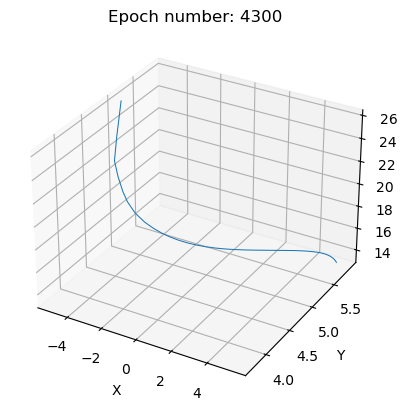

10.0 15.0 2.6666666666666665
tf.Tensor([4605.476], shape=(1,), dtype=float32)
52.660919189453125 3209.9462890625 13.331697463989258
52.05763626098633 3231.65185546875 13.106021881103516
51.008888244628906 3379.96435546875 12.868977546691895
50.33685302734375 3104.412353515625 12.568103790283203
49.609130859375 3010.593994140625 12.28564453125
49.08591079711914 3190.14990234375 12.004899978637695
48.607154846191406 2982.923828125 11.690109252929688
48.14198303222656 2980.42919921875 11.40407943725586
47.8665771484375 2945.47607421875 11.111489295959473
47.5860710144043 2873.32275390625 10.815505981445312
47.14550018310547 2934.111328125 10.529175758361816
46.625877380371094 3022.67822265625 10.299514770507812
46.32932662963867 2814.125 10.039287567138672
45.993614196777344 2867.5244140625 9.814931869506836
45.72499084472656 2863.78564453125 9.648947715759277
45.696617126464844 2986.353271484375 9.449433326721191
45.905025482177734 2996.52392578125 9.199371337890625
45.89372253417969 286

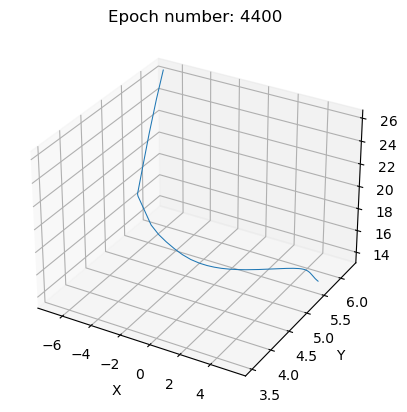

10.0 15.0 2.6666666666666665
tf.Tensor([1735.3611], shape=(1,), dtype=float32)
29.112144470214844 1454.581298828125 2.29215931892395
29.963356018066406 1491.889892578125 1.7926912307739258
30.22014808654785 1519.974609375 1.4927273988723755
29.439184188842773 1499.4188232421875 1.4221326112747192
28.57771873474121 1507.340087890625 1.405207633972168
28.401111602783203 1499.1136474609375 1.2923753261566162
28.68246841430664 1507.52978515625 1.1945452690124512
28.612831115722656 1487.3082275390625 1.309499979019165
28.329296112060547 1453.98828125 1.578023910522461
28.61348533630371 1460.812744140625 1.4394854307174683
29.176000595092773 1490.428955078125 1.0761692523956299
29.074867248535156 1499.689453125 0.9485747218132019
28.32018280029297 1481.9813232421875 1.0413802862167358
27.885618209838867 1466.416015625 1.1704264879226685
28.045507431030273 1455.522705078125 1.1818808317184448
28.157760620117188 1451.52099609375 1.225490927696228
27.941967010498047 1430.7032470703125 1.3475599

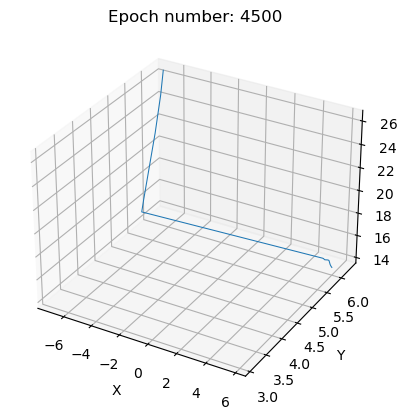

10.0 15.0 2.6666666666666665
tf.Tensor([1433.5701], shape=(1,), dtype=float32)
25.480653762817383 1300.787109375 0.9004608988761902
25.6646671295166 1310.5999755859375 0.8376748561859131
24.963956832885742 1222.297119140625 1.038175106048584
24.620079040527344 1219.6322021484375 1.313878059387207
25.314193725585938 1247.1717529296875 1.114890217781067
25.379592895507812 1231.4423828125 0.9828833937644958
24.569049835205078 1173.311767578125 1.1598401069641113
24.472156524658203 1181.386962890625 1.0541917085647583
24.98537826538086 1189.8243408203125 0.8406171798706055
24.91482162475586 1132.7730712890625 1.0961229801177979
24.753063201904297 1127.5831298828125 1.3767385482788086
25.191436767578125 1269.10205078125 0.7102926969528198
24.43115234375 1132.9327392578125 1.2971742153167725
24.81039810180664 1158.25537109375 0.8048802018165588
24.639184951782227 1104.802734375 1.358612060546875
25.464683532714844 1401.893798828125 0.6240081191062927
24.420127868652344 1262.0965576171875 2.3

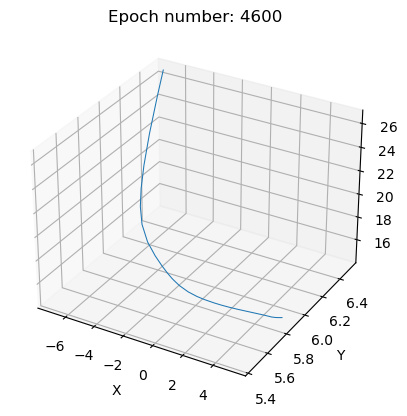

10.0 15.0 2.6666666666666665
tf.Tensor([1688.0912], shape=(1,), dtype=float32)
21.538818359375 1386.607421875 3.4931020736694336
22.00356674194336 1462.838134765625 1.903433084487915
22.99480438232422 1595.4996337890625 0.7635133266448975
23.11148452758789 1608.3516845703125 0.6877099275588989
22.30512046813965 1485.959228515625 1.3726825714111328
21.687744140625 1404.13818359375 2.687230348587036
22.723278045654297 1538.25732421875 0.9133226275444031
23.250694274902344 1595.074462890625 0.6464836001396179
23.21823501586914 1570.515625 0.7961730360984802
22.879791259765625 1514.1700439453125 1.298245906829834
22.639724731445312 1463.859375 1.845292091369629
22.7205867767334 1443.0390625 1.8999133110046387
22.992769241333008 1457.4742431640625 1.56321382522583
23.186357498168945 1494.580078125 1.1977760791778564
23.12287139892578 1522.526123046875 0.9256259799003601
22.76101303100586 1527.4556884765625 0.8000973463058472
22.265148162841797 1524.01171875 0.7710829973220825
21.86349868774

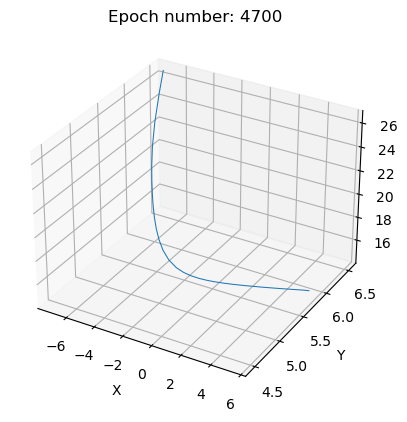

10.0 15.0 2.6666666666666665
tf.Tensor([1610.5007], shape=(1,), dtype=float32)
24.29706382751465 1358.8885498046875 1.7244192361831665
23.092227935791016 1322.860595703125 2.77950119972229
23.25418472290039 1481.8984375 0.7419182062149048
23.303625106811523 1573.52978515625 0.4397823214530945
23.385395050048828 1557.78076171875 0.40688833594322205
23.36520767211914 1432.491455078125 0.7379385232925415
23.199222564697266 1386.596435546875 2.5457041263580322
24.507892608642578 1444.406005859375 0.7517836093902588
25.106807708740234 1532.5987548828125 0.4251205027103424
24.71890640258789 1506.0145263671875 0.5397111177444458
23.783859252929688 1389.688720703125 1.1227937936782837
22.886302947998047 1315.8330078125 2.8575854301452637
23.572799682617188 1445.8616943359375 1.071345567703247
24.18286895751953 1508.4619140625 0.7899841666221619
24.739566802978516 1509.759765625 0.7121662497520447
24.943370819091797 1462.09814453125 0.8275037407875061
24.4921875 1352.931884765625 1.611521959304

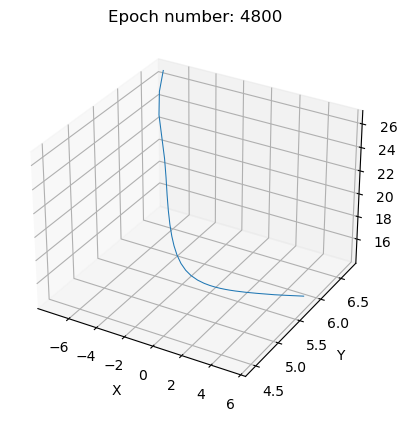

10.0 15.0 2.6666666666666665
tf.Tensor([1576.4818], shape=(1,), dtype=float32)
24.109516143798828 1403.2236328125 1.1489300727844238
23.312435150146484 1374.6212158203125 2.0739519596099854
23.242916107177734 1382.447998046875 1.8744440078735352
23.849048614501953 1412.9688720703125 0.9143153429031372
24.47112274169922 1480.489501953125 0.5481444001197815
24.70557975769043 1492.927490234375 0.5380371809005737
24.513729095458984 1393.906494140625 0.7925745248794556
24.04931640625 1366.929443359375 1.704140305519104
24.23685073852539 1339.5009765625 1.0993002653121948
24.365888595581055 1432.327880859375 0.7910987138748169
24.097808837890625 1318.8040771484375 1.0229905843734741
23.62417984008789 1359.1810302734375 2.057314872741699
24.56886100769043 1731.52490234375 0.7830138206481934
25.645784378051758 1658.6849365234375 0.7445186376571655
26.89857292175293 1616.453857421875 0.7377560138702393
27.39459228515625 1642.0726318359375 0.7778889536857605
26.8096981048584 1623.33935546875 0.8

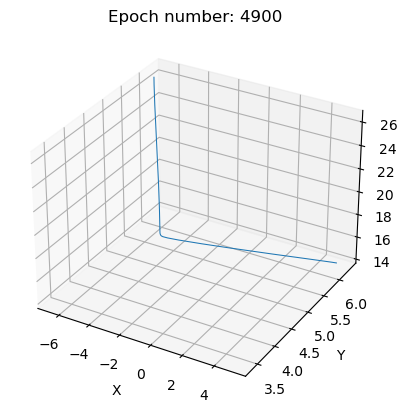

10.0 15.0 2.6666666666666665
tf.Tensor([1861.908], shape=(1,), dtype=float32)
28.502519607543945 1417.542236328125 3.37835431098938
29.148052215576172 1477.481689453125 2.2767701148986816
29.43053436279297 1552.523681640625 1.2046384811401367
28.487674713134766 1492.710693359375 1.5702043771743774
28.91699981689453 1555.9498291015625 0.67374187707901
28.51593017578125 1492.707275390625 1.1227494478225708
28.07588768005371 1509.160400390625 0.7253209948539734
27.136188507080078 1508.0908203125 0.7285393476486206
27.19021987915039 1553.9664306640625 0.34038084745407104
25.802661895751953 1385.2862548828125 3.3527042865753174
30.13874053955078 2579.9619140625 0.11609458923339844
27.976276397705078 2310.945556640625 0.025481581687927246
25.635480880737305 2006.260986328125 0.1940002739429474
23.667461395263672 964.67724609375 24.220457077026367
30.875276565551758 2513.628662109375 0.04274771362543106
33.295387268066406 3673.923095703125 0.04650931805372238
36.090572357177734 5997.018066406

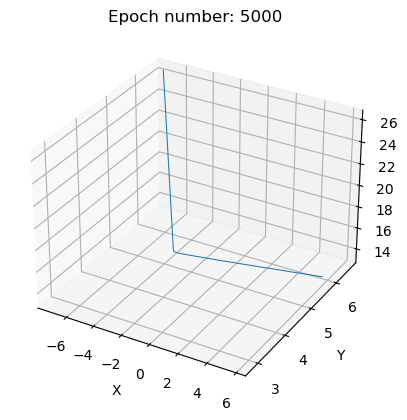

10.0 15.0 2.6666666666666665
tf.Tensor([1854.5842], shape=(1,), dtype=float32)
33.73637390136719 1696.2388916015625 1.020436406135559
34.0998649597168 1667.5008544921875 1.0697262287139893
33.309173583984375 1572.18505859375 1.6889517307281494
32.024173736572266 1517.9488525390625 2.890310287475586
33.19829559326172 1678.60595703125 0.845842719078064
33.56561279296875 1774.3558349609375 0.6382651329040527
32.99474334716797 1768.31884765625 0.6037033796310425
32.201480865478516 1694.041015625 0.683968722820282
31.964622497558594 1562.7669677734375 1.201843023300171
31.33847999572754 1529.389404296875 3.571406126022339
33.12315368652344 1714.5693359375 0.632892370223999
32.516990661621094 1753.0701904296875 0.516615629196167
30.99209976196289 1776.91748046875 0.5824211835861206
30.418354034423828 1700.96044921875 0.7256799936294556
30.88474464416504 1545.665771484375 1.274812936782837
30.62069320678711 1477.3720703125 3.2764248847961426
30.590953826904297 1488.5068359375 1.92505812644958

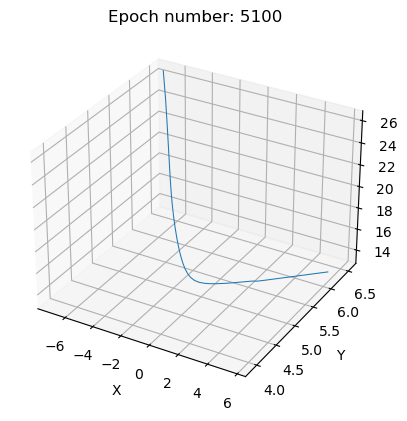

10.0 15.0 2.6666666666666665
tf.Tensor([1537.0886], shape=(1,), dtype=float32)
24.40347671508789 1374.822265625 1.6579774618148804
25.06787872314453 1464.29443359375 0.8364109992980957
25.49129295349121 1474.16943359375 0.7973818778991699
25.119810104370117 1391.17822265625 1.1654274463653564
24.25298309326172 1370.326416015625 2.148393154144287
25.54013442993164 1540.69677734375 0.6980980038642883
26.516944885253906 1608.3341064453125 0.6200734376907349
26.352893829345703 1611.9013671875 0.6454823017120361
25.47706413269043 1550.1473388671875 0.7407097816467285
24.648677825927734 1699.133544921875 0.9078834652900696
27.348514556884766 1636.8436279296875 0.8872639536857605
28.286205291748047 1768.67236328125 0.9953182935714722
27.30440902709961 1673.4593505859375 1.1767685413360596
25.378360748291016 1501.1435546875 1.420589804649353
23.46564483642578 1700.2510986328125 1.8678884506225586
25.080829620361328 1376.617919921875 1.9952175617218018
26.66986083984375 1464.243408203125 2.2712

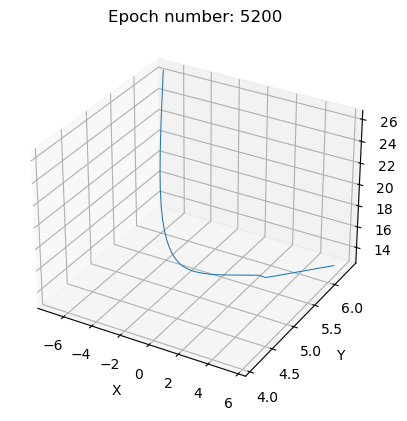

10.0 15.0 2.6666666666666665
tf.Tensor([1617.0964], shape=(1,), dtype=float32)
25.274015426635742 1361.9058837890625 1.9315922260284424
25.433490753173828 1306.193359375 2.4036622047424316
25.033607482910156 1314.33642578125 2.3818469047546387
25.35770606994629 1386.6357421875 1.446200966835022
26.32732391357422 1447.110107421875 0.8888739347457886
26.540586471557617 1456.3895263671875 0.7605283856391907
25.41284942626953 1405.8798828125 0.9747206568717957
24.73621368408203 1395.673828125 1.2587556838989258
25.546417236328125 1421.871337890625 0.6963812112808228
25.09345245361328 1436.4183349609375 0.5980189442634583
24.02864646911621 1369.86083984375 1.1392600536346436
24.12110710144043 1384.48828125 0.7910729646682739
24.453754425048828 1361.035400390625 0.9184377193450928
24.258272171020508 1352.066650390625 0.8853138089179993
23.80710792541504 1344.737548828125 0.8421043753623962
23.88460922241211 1323.2437744140625 1.0201712846755981
25.05023956298828 1945.632568359375 0.255002498

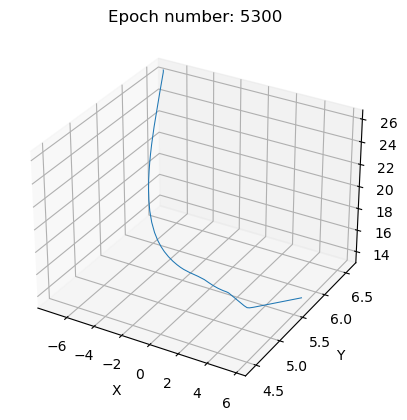

10.0 15.0 2.6666666666666665
tf.Tensor([2474.58], shape=(1,), dtype=float32)
31.588577270507812 2193.72705078125 1.7607210874557495
30.78200912475586 2069.466064453125 2.5609524250030518
31.33523178100586 2023.1468505859375 3.247483491897583
31.783679962158203 1991.2581787109375 3.7195565700531006
31.11269187927246 1924.60400390625 3.975266933441162
29.80638885498047 1842.73681640625 4.045729160308838
29.17727279663086 1787.931884765625 3.9580249786376953
29.777856826782227 1718.116943359375 3.7529914379119873
30.240253448486328 1691.5556640625 3.507746934890747
29.729328155517578 1668.96240234375 3.2929089069366455
28.775619506835938 1580.05810546875 3.183126449584961
27.297893524169922 1481.1434326171875 3.3141703605651855
25.860496520996094 1358.866455078125 3.8538894653320312
24.79469108581543 1273.596435546875 4.267720699310303
24.40915870666504 1402.546630859375 2.9735279083251953
23.328685760498047 964.9221801757812 23.079517364501953
29.381431579589844 1623.447021484375 4.77038

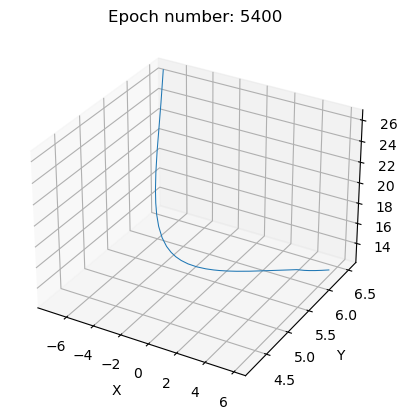

10.0 15.0 2.6666666666666665
tf.Tensor([1518.3805], shape=(1,), dtype=float32)
24.043392181396484 1396.701171875 0.9555456638336182
23.939796447753906 1395.405517578125 0.9540975093841553
23.93679428100586 1390.685302734375 0.9821426272392273
24.0977783203125 1393.30712890625 0.9290828704833984
24.25833511352539 1395.1533203125 0.8877545595169067
24.25838279724121 1391.7822265625 0.8969681859016418
24.130624771118164 1391.9107666015625 0.8669332265853882
23.97236442565918 1389.63671875 0.8632781505584717
23.90036392211914 1383.7501220703125 0.8918614387512207
23.95585060119629 1383.2359619140625 0.8596535325050354
23.993175506591797 1376.94091796875 0.8824475407600403
23.964614868164062 1373.765380859375 0.8688303828239441
23.85891342163086 1369.220947265625 0.8621391654014587
23.75363540649414 1363.342041015625 0.8622530102729797
23.7281494140625 1361.03662109375 0.8173681497573853
23.706565856933594 1348.956298828125 0.8601310849189758
23.734176635742188 1355.768798828125 0.726840257

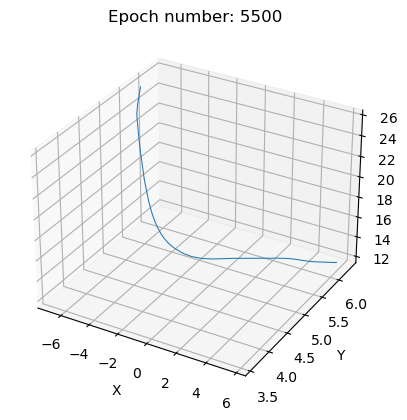

10.0 15.0 2.6666666666666665
tf.Tensor([2236.1018], shape=(1,), dtype=float32)
32.30793380737305 1803.91650390625 3.4878134727478027
33.0728645324707 1803.827392578125 1.7186715602874756
32.811790466308594 1910.61474609375 1.0287964344024658
31.174890518188477 2037.05322265625 0.8576956987380981
29.81739044189453 1881.308837890625 0.9440029263496399
29.302410125732422 1758.19140625 1.2890197038650513
29.176448822021484 1692.1314697265625 2.1774091720581055
28.99089813232422 1604.3563232421875 3.321025848388672
28.720388412475586 1556.983154296875 3.2345917224884033
28.3127384185791 1571.8541259765625 2.1060659885406494
27.715652465820312 1627.953125 1.5406863689422607
27.375612258911133 1657.5858154296875 1.4038066864013672
27.140201568603516 1614.61767578125 1.4386826753616333
26.9437255859375 1504.71630859375 1.7060714960098267
27.05001449584961 1485.193359375 2.086272716522217
27.356977462768555 1431.530029296875 2.4947967529296875
27.55420684814453 1412.1925048828125 2.677429676055

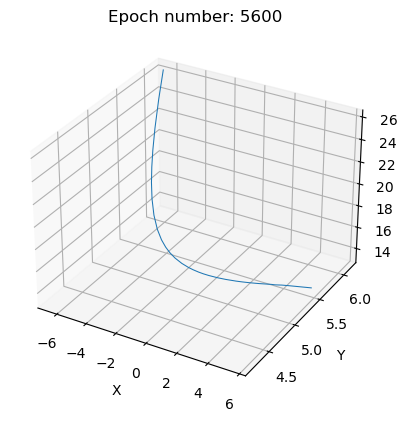

10.0 15.0 2.6666666666666665
tf.Tensor([1704.8762], shape=(1,), dtype=float32)
29.568387985229492 1716.0413818359375 0.2668954133987427
27.935741424560547 1507.291259765625 0.8216916918754578
25.157737731933594 1266.58642578125 6.076150894165039
32.08182144165039 2134.4599609375 0.38365817070007324
32.162227630615234 2274.703125 0.4122830033302307
27.293437957763672 1904.8677978515625 0.03263821080327034
22.37166404724121 1340.76171875 6.95719575881958
23.858545303344727 1521.072998046875 2.3078553676605225
26.752700805664062 1711.4852294921875 0.36390218138694763
28.213912963867188 1719.7196044921875 0.29342177510261536
26.77496337890625 1447.8970947265625 1.8338807821273804
25.056034088134766 1196.730712890625 6.982489109039307
29.281814575195312 1763.7852783203125 0.4481744170188904
29.133163452148438 1804.3621826171875 0.290996789932251
24.879337310791016 1407.3653564453125 1.7898461818695068
21.95398712158203 1219.582763671875 6.747651100158691
25.243011474609375 1650.05322265625 

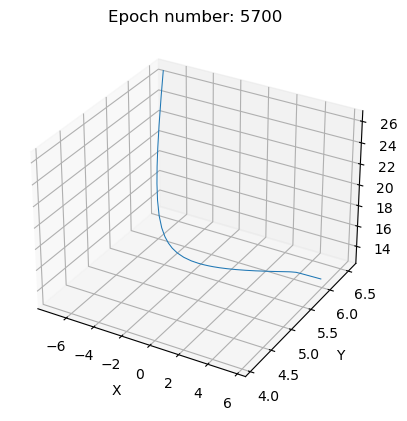

10.0 15.0 2.6666666666666665
tf.Tensor([1532.6646], shape=(1,), dtype=float32)
25.206518173217773 1404.1300048828125 1.0319864749908447
25.2862606048584 1407.955078125 0.9917270541191101
25.287368774414062 1406.1552734375 1.0081632137298584
25.254756927490234 1402.605712890625 1.0431647300720215
25.296283721923828 1405.3135986328125 1.0139942169189453
25.322101593017578 1407.649658203125 0.9894474148750305
25.273448944091797 1404.908203125 1.0158942937850952
25.258991241455078 1404.346435546875 1.0206122398376465
25.301307678222656 1407.236328125 0.9900587201118469
25.299299240112305 1406.4332275390625 0.9968320727348328
25.27028465270996 1403.476318359375 1.025651216506958
25.295574188232422 1404.5535888671875 1.013331413269043
25.321941375732422 1406.1435546875 0.9962119460105896
25.293270111083984 1404.224853515625 1.0144020318984985
25.278907775878906 1403.5400390625 1.020376443862915
25.30694580078125 1405.739501953125 0.9969363808631897
25.309066772460938 1405.7073974609375 0.996

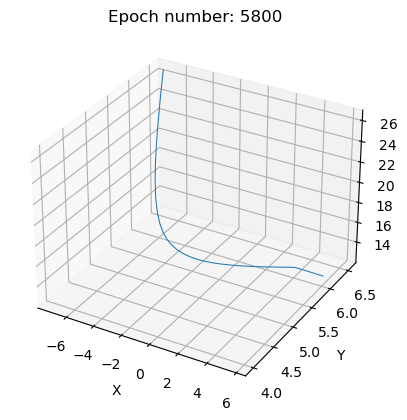

10.0 15.0 2.6666666666666665
tf.Tensor([1524.0562], shape=(1,), dtype=float32)
25.447486877441406 1398.94970703125 0.9960130453109741
25.448413848876953 1398.877685546875 0.9961444735527039
25.449481964111328 1398.8154296875 0.9961790442466736
25.450944900512695 1398.784912109375 0.9959077835083008
25.452022552490234 1398.7347412109375 0.9958109855651855
25.452733993530273 1398.66552734375 0.9959291815757751
25.453874588012695 1398.62744140625 0.9957418441772461
25.45515251159668 1398.594482421875 0.9954950213432312
25.456024169921875 1398.53076171875 0.9955731630325317
25.45704460144043 1398.47265625 0.9955856800079346
25.458438873291016 1398.4404296875 0.99534672498703
25.459545135498047 1398.3916015625 0.9952746033668518
25.46036148071289 1398.3275146484375 0.9953604936599731
25.46152114868164 1398.2900390625 0.9951872229576111
25.462692260742188 1398.255859375 0.9949702620506287
25.4635009765625 1398.1953125 0.9950406551361084
25.464496612548828 1398.1453857421875 0.994986116886138

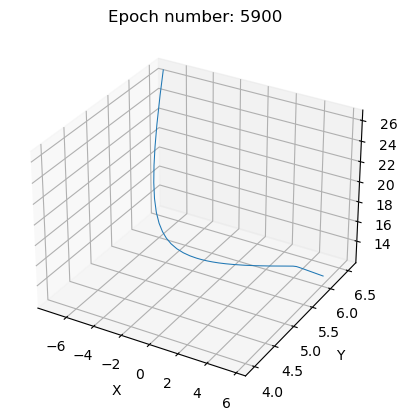

10.0 15.0 2.6666666666666665
tf.Tensor([1519.3015], shape=(1,), dtype=float32)
25.536563873291016 1394.669921875 0.9905320405960083
25.537342071533203 1394.6336669921875 0.9904840588569641
25.53811264038086 1394.5968017578125 0.9904437065124512
25.53887176513672 1394.559326171875 0.990401029586792
25.53957748413086 1394.52001953125 0.9903779029846191
25.54027557373047 1394.481689453125 0.9903523921966553
25.54107666015625 1394.4486083984375 0.9902609586715698
25.541790008544922 1394.40966796875 0.9902381896972656
25.542465209960938 1394.3675537109375 0.9902450442314148
25.54327392578125 1394.333984375 0.9901760220527649
25.544044494628906 1394.299072265625 0.9901197552680969
25.544715881347656 1394.2584228515625 0.9901113510131836
25.5454158782959 1394.219970703125 0.9900858402252197
25.546207427978516 1394.188232421875 0.9899915456771851
25.546897888183594 1394.14892578125 0.9899792671203613
25.547592163085938 1394.108642578125 0.9899703860282898
25.54836654663086 1394.0736083984375 0

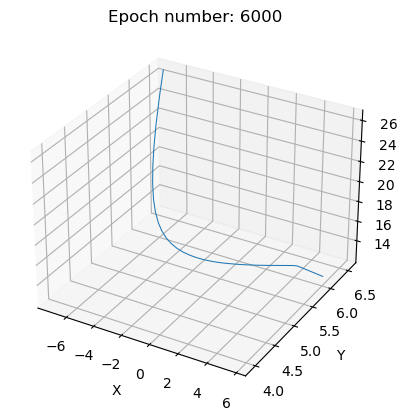

10.0 15.0 2.6666666666666665
tf.Tensor([1515.3519], shape=(1,), dtype=float32)
25.60582733154297 1391.033935546875 0.9867135882377625
25.606422424316406 1390.993896484375 0.9867125749588013
25.607147216796875 1390.9608154296875 0.9866371750831604
25.607837677001953 1390.9254150390625 0.9865841269493103
25.608421325683594 1390.884521484375 0.9865919351577759
25.609107971191406 1390.8504638671875 0.9865317940711975
25.609830856323242 1390.819091796875 0.986441969871521
25.61043930053711 1390.781005859375 0.9864252209663391
25.611045837402344 1390.7412109375 0.9864213466644287
25.611801147460938 1390.709228515625 0.9863372445106506
25.612457275390625 1390.6737060546875 0.986300528049469
25.613040924072266 1390.634521484375 0.986281156539917
25.613712310791016 1390.5997314453125 0.986229658126831
25.614408493041992 1390.56591796875 0.986163854598999
25.615032196044922 1390.52880859375 0.9861396551132202
25.615680694580078 1390.4921875 0.9861054420471191
25.616352081298828 1390.45654296875 

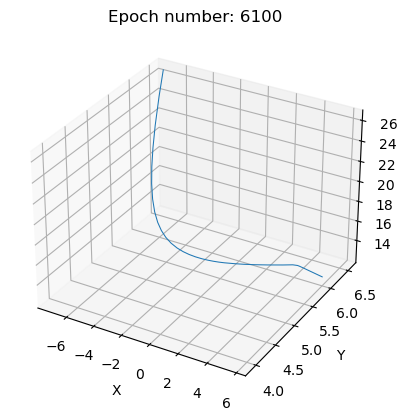

10.0 15.0 2.6666666666666665
tf.Tensor([1511.9022], shape=(1,), dtype=float32)
25.660537719726562 1388.0516357421875 0.9815889596939087
25.660892486572266 1388.02783203125 0.9815088510513306
25.661285400390625 1388.0081787109375 0.9814051985740662
25.66159439086914 1387.98388671875 0.9813283681869507
25.661865234375 1387.95849609375 0.9812731742858887
25.66221046447754 1387.9366455078125 0.9811757802963257
25.662551879882812 1387.9150390625 0.9810718894004822
25.662803649902344 1387.889892578125 0.9810089468955994
25.66309356689453 1387.866943359375 0.9809240102767944
25.663427352905273 1387.8447265625 0.9808244705200195
25.66372299194336 1387.8221435546875 0.9807296395301819
25.663978576660156 1387.796630859375 0.9806597828865051
25.664260864257812 1387.77392578125 0.9805604815483093
25.66455841064453 1387.751708984375 0.9804452061653137
25.66478157043457 1387.7275390625 0.980358898639679
25.66499137878418 1387.7010498046875 0.9802926182746887
25.665340423583984 1387.68017578125 0.980

KeyboardInterrupt: 

In [643]:
train_lorenz(80000)

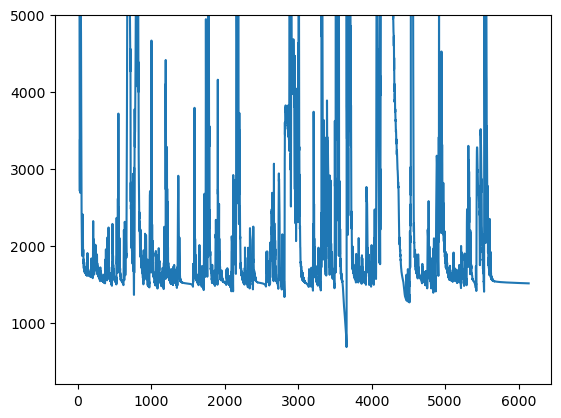

In [648]:
plt.plot(losses)
plt.ylim([200, 5000])
plt.show()